In [ ]:
import yfinance as yf
import datetime
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import plotly.graph_objects as go

ModuleNotFoundError: ignored

In [ ]:
!pip install --quiet --upgrade tensorflow-federated

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 721.6/721.6 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.7/73.7 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 63.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.7/33.7 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.7/257.7 kB 24.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.2/241.2 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
def fetch_stock_data(ticker_symbol, start_date, end_date):
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close', 'Volume']]
    df_main = stock_data.iloc[:-4]
    df_future = stock_data.iloc[-5:]
    return df_main, df_future

def main():
    companies = ["NVDA", "TSLA", "FDX", "ABNB", "AAPL", "GOOG", "ORCL", "IBM", "MSFT"]
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=180)
    all_data = {}
    all_future_data = {}
    for company in companies:
        df_main, df_future = fetch_stock_data(company, start_date, end_date)
        all_data[company] = df_main
        all_future_data[company + "_future"] = df_future
    return all_data, all_future_data

def preprocess_for_federated_learning(company_data):
    def dataframe_to_dataset(dataframe):
        dataframe = dataframe.copy()
        labels = dataframe.pop('Close')

        # Since you only want to use the 'Close' prices, there's no need for a dictionary or OrderedDict.
        ds = tf.data.Dataset.from_tensor_slices((dataframe.values, labels))
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(5)
        return ds

    client_datasets = []
    for _, df in company_data.items():
        ds = dataframe_to_dataset(df)
        client_datasets.append(ds)
    return client_datasets

def create_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(30, activation=tf.nn.leaky_relu, input_shape=(5, 1)),  # Adjusted input shape to (5,1) for Close only
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn(client_datasets):
    keras_model = create_lstm_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

all_data, _ = main()
client_datasets = preprocess_for_federated_learning(all_data)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    lambda: model_fn(client_datasets),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)
state = iterative_process.initialize()

NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', nan), ('loss', nan), ('num_examples', 1089), ('num_batches', 225)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 1)]))])
round  1, metrics=OrderedDict([('distributor', ())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
round  0, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('mean_squared_error', nan), ('loss', nan), ('num_examples', 1035), ('num_batches', 207)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 1)]))])
round  1, metrics=OrderedDict([('distributor', ())

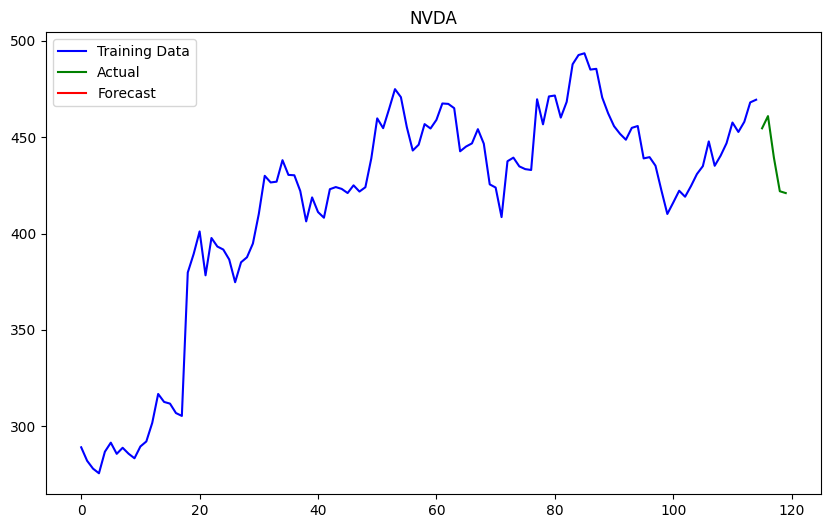

1/1 [==============================] - 0s 172ms/step
[[nan]]
1/1 [==============================] - 0s 26ms/step
[[nan]]
1/1 [==============================] - 0s 31ms/step
[[nan]]
1/1 [==============================] - 0s 29ms/step
[[nan]]
1/1 [==============================] - 0s 24ms/step
[[nan]]


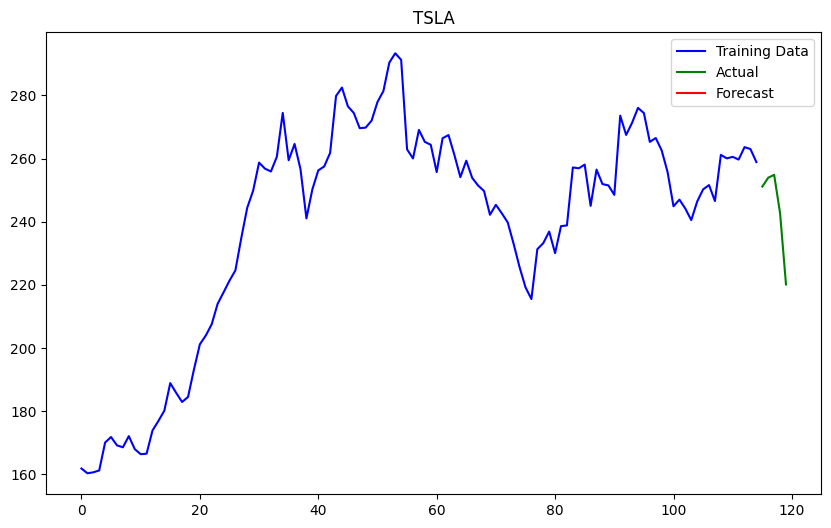

1/1 [==============================] - 0s 165ms/step
[[nan]]
1/1 [==============================] - 0s 20ms/step
[[nan]]
1/1 [==============================] - 0s 22ms/step
[[nan]]
1/1 [==============================] - 0s 22ms/step
[[nan]]
1/1 [==============================] - 0s 30ms/step
[[nan]]


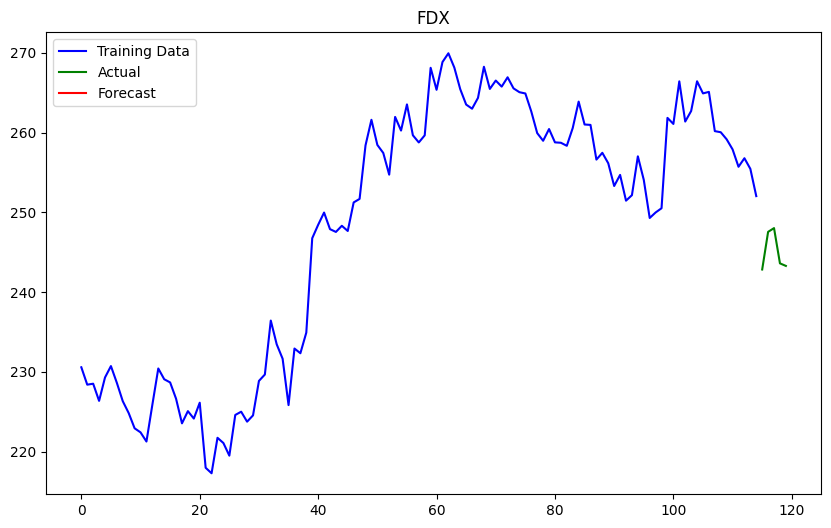

1/1 [==============================] - 0s 166ms/step
[[nan]]
1/1 [==============================] - 0s 22ms/step
[[nan]]
1/1 [==============================] - 0s 21ms/step
[[nan]]
1/1 [==============================] - 0s 24ms/step
[[nan]]
1/1 [==============================] - 0s 21ms/step
[[nan]]


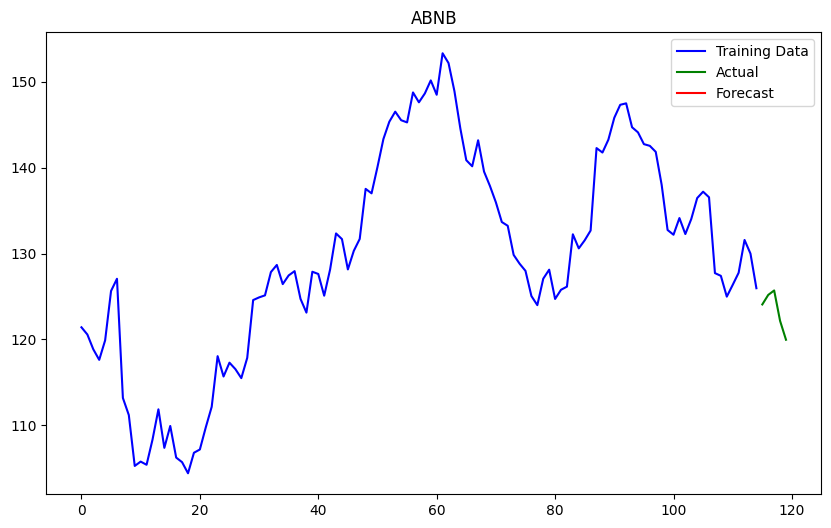

1/1 [==============================] - 0s 248ms/step
[[nan]]
1/1 [==============================] - 0s 31ms/step
[[nan]]
1/1 [==============================] - 0s 30ms/step
[[nan]]
1/1 [==============================] - 0s 33ms/step
[[nan]]
1/1 [==============================] - 0s 36ms/step
[[nan]]


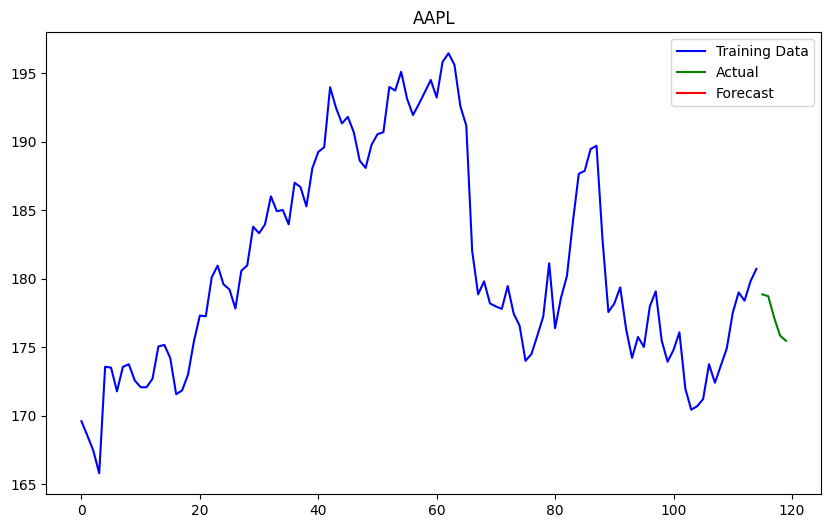

1/1 [==============================] - 0s 244ms/step
[[nan]]
1/1 [==============================] - 0s 32ms/step
[[nan]]
1/1 [==============================] - 0s 34ms/step
[[nan]]
1/1 [==============================] - 0s 39ms/step
[[nan]]
1/1 [==============================] - 0s 42ms/step
[[nan]]


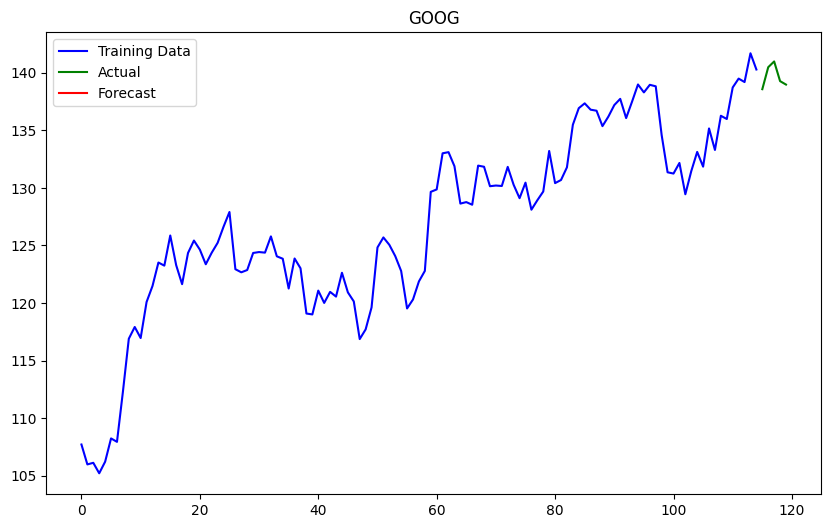

1/1 [==============================] - 0s 262ms/step
[[nan]]
1/1 [==============================] - 0s 30ms/step
[[nan]]
1/1 [==============================] - 0s 36ms/step
[[nan]]
1/1 [==============================] - 0s 44ms/step
[[nan]]
1/1 [==============================] - 0s 37ms/step
[[nan]]


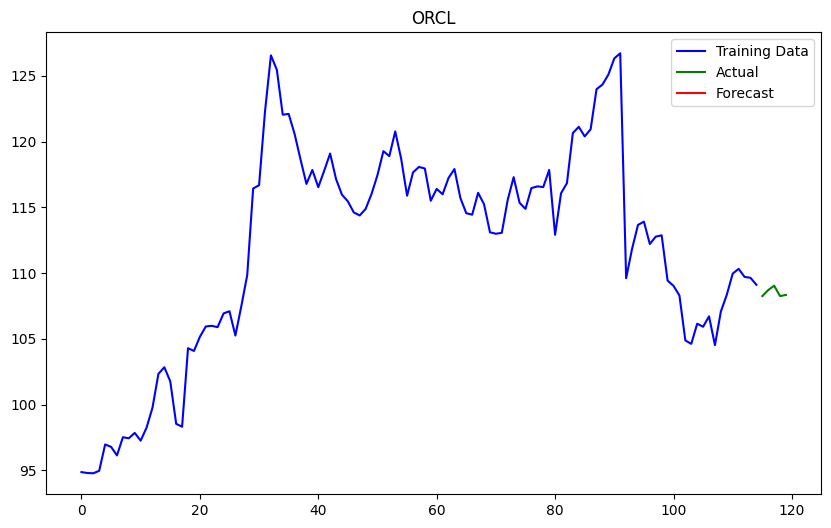

1/1 [==============================] - 0s 161ms/step
[[nan]]
1/1 [==============================] - 0s 20ms/step
[[nan]]
1/1 [==============================] - 0s 23ms/step
[[nan]]
1/1 [==============================] - 0s 25ms/step
[[nan]]
1/1 [==============================] - 0s 30ms/step
[[nan]]


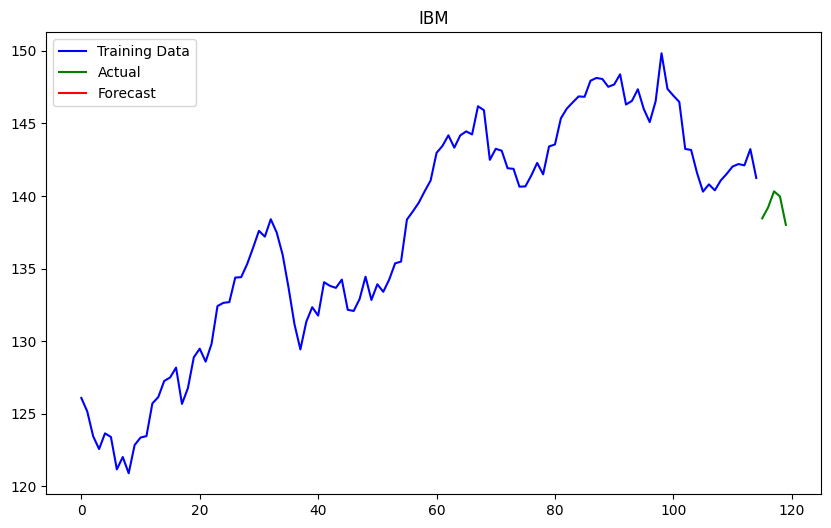

1/1 [==============================] - 0s 290ms/step
[[nan]]
1/1 [==============================] - 0s 32ms/step
[[nan]]
1/1 [==============================] - 0s 33ms/step
[[nan]]
1/1 [==============================] - 0s 34ms/step
[[nan]]
1/1 [==============================] - 0s 38ms/step
[[nan]]


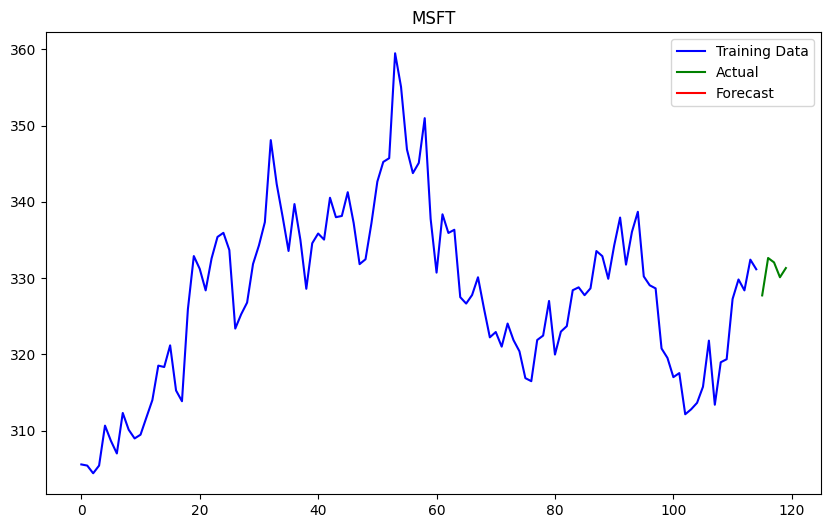

In [ ]:
import yfinance as yf
import datetime
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import numpy as np

def fetch_stock_data(ticker_symbol, start_date, end_date):
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close', 'Volume']]
    stock_data = stock_data.iloc[-120:]  # Only extract the last 120 data points
    df_main = stock_data.iloc[:-5]       # Use the first 115 data points for training
    df_future = stock_data.iloc[-5:]     # Use the latest 5 data points for testing
    return df_main, df_future

def preprocess_for_federated_learning(company_data):
    def dataframe_to_dataset(dataframe):
        dataframe = dataframe.copy()
        labels = dataframe.pop('Close')
        ds = tf.data.Dataset.from_tensor_slices((dataframe.values, labels))
        ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(5)
        return ds

    client_datasets = []
    for _, df in company_data.items():
        ds = dataframe_to_dataset(df)
        client_datasets.append(ds)
    return client_datasets

def create_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(30, activation=tf.nn.leaky_relu, input_shape=(5, 1)),
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn(client_datasets):
    keras_model = create_lstm_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

def plot_forecast(train, actual, forecast, title):
    plt.figure(figsize=(10, 6))
    plt.plot(np.arange(len(train)), train, label="Training Data", color="blue")
    plt.plot(np.arange(len(train), len(train) + len(actual)), actual, label="Actual", color="green")
    plt.plot(np.arange(len(train), len(train) + len(forecast)), forecast, label="Forecast", color="red")
    plt.title(title)
    plt.legend()
    plt.show()

all_data, future_data = main()
client_datasets = preprocess_for_federated_learning(all_data)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    lambda: model_fn(client_datasets),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)
state = iterative_process.initialize()

NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

# Forecast and plot
# Extracting weights from the federated model
federated_weights = state.global_model_weights.trainable

# Assign the federated weights to the Keras model
keras_model = create_lstm_model()
keras_model.set_weights(federated_weights)

federated_weights = state.global_model_weights.trainable

for company in all_data.keys():
    # Create a new model for the company and set federated weights
    company_model = create_lstm_model()
    company_model.set_weights(federated_weights)

    # Get data and preprocess
    train_df = all_data[company]
    train_labels = train_df.pop('Close')
    train_data = train_df.values

    # Prepare sequences for fine-tuning
    train_X = []
    train_Y = []
    for i in range(len(train_data)-5):
        train_X.append(train_data[i:i+5])
        train_Y.append(train_labels[i+5])

    train_X = np.array(train_X)
    train_Y = np.array(train_Y)

    # Fine-tune the model on the company's local data
    company_model.compile(optimizer='SGD', loss='mse', metrics=['mse'])
    company_model.fit(train_X, train_Y, epochs=10, verbose=0)

    # Prediction
    actual = future_data[company+"_future"]["Close"].values
    forecast = []
    input_sequence_values = train_labels.values[-5:]  # Adjusted to consider only last 5 days for prediction input
    input_sequence = input_sequence_values.reshape(1, 5, 1)

    for i in range(5):
        predicted = company_model.predict(input_sequence)
        forecast.append(predicted[0][0])
        print(predicted)
        input_sequence = np.roll(input_sequence, shift=-1)
        input_sequence[0, -1, 0] = predicted

    plot_forecast(train_labels.values, actual, forecast, company)


In [ ]:
import yfinance as yf
import datetime
import tensorflow as tf
import tensorflow_federated as tff
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
import plotly.graph_objects as go

def fetch_stock_data(ticker_symbol, start_date, end_date):
    stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
    stock_data = stock_data[['Close']]

    train_end = int(0.8 * len(stock_data))  # 80% of data for training

    df_train = stock_data.iloc[:train_end]
    df_val = stock_data.iloc[train_end:-5]  # 20% of data minus last 5 days for validation
    df_future = stock_data.iloc[-5:]        # Use the latest 5 data points for forecasting

    return df_train, df_val, df_future

def main():
    companies = ["NVDA", "TSLA", "FDX", "ABNB", "AAPL", "GOOG", "ORCL", "IBM", "MSFT",
                 "AMZN", "PFE", "WMT", "JPM", "JNJ", "XOM", "DIS", "PG", "KO", "CVX", "V",
                 "NKE", "MCD", "MMM", "BA", "UNH", "HD", "GS", "NFLX", "SBUX"]
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=180)
    all_data = {}
    all_val_data = {}
    all_future_data = {}
    for company in companies:
        df_train, df_val, df_future = fetch_stock_data(company, start_date, end_date)
        all_data[company] = df_train
        all_val_data[company + "_val"] = df_val
        all_future_data[company + "_future"] = df_future
    return all_data, all_val_data, all_future_data

def preprocess_for_federated_learning(company_data):
    def dataframe_to_dataset(dataframe):
        close_values = dataframe['Close'].values
        sequences = []
        labels = []

        # Create sliding window sequences and corresponding labels
        for i in range(len(close_values) - look_back):
          sequences.append(close_values[i:i+look_back])
          labels.append(close_values[i+look_back])

        ds = tf.data.Dataset.from_tensor_slices((np.array(sequences).reshape(-1, 5, 1), labels))
        ds = ds.shuffle(buffer_size=len(sequences))
        ds = ds.batch(5)
        return ds

    client_datasets = []
    for _, df in company_data.items():
        ds = dataframe_to_dataset(df)
        client_datasets.append(ds)
    return client_datasets

def create_lstm_model():
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='tanh', input_shape=(look_back, 1)),
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn(client_datasets):
    keras_model = create_lstm_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

def plot_forecast(train_dates, train, val_dates, val, forecast_val, future_dates, forecast_future, future_data_actual, title, company):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=train_dates, y=train,
                    mode='lines',
                    name=f'Training Data - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=val,
                    mode='lines',
                    name=f'Validation Actual - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=forecast_val,
                    mode='lines',
                    name=f'Validation Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=forecast_future,
                    mode='lines',
                    name=f'Future Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=future_data_actual,
                    mode='lines',
                    name=f'Future Actual - {company}'))

    # Set title and layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            showticklabels=True,
            tickfont=dict(
                family='Arial',
                size=12,
                color='rgb(82, 82, 82)',
            ),
        ),
        yaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=False,
            zeroline=False,
            showticklabels=True,
        ),
        autosize=False,
        margin=dict(
            autoexpand=False,
            l=100,
            r=20,
            t=110,
        ),
        showlegend=True,
        plot_bgcolor='white',
    )
    fig.show()

all_data, all_val_data, future_data = main()
client_datasets = preprocess_for_federated_learning(all_data)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    lambda: model_fn(client_datasets),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.005),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)
state = iterative_process.initialize()

NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

# Forecast and plot
federated_weights = state.global_model_weights.trainable


def forecast_for_company(train_data, val_data, federated_weights):
    # Initialize a new model and set federated weights
    company_model = create_lstm_model()
    company_model.set_weights(federated_weights)

    # Prepare sequences for fine-tuning
    train_X = []
    train_Y = []
    for i in range(len(train_data) - look_back):
        train_X.append(train_data[i:i+look_back])
        train_Y.append(train_data[i+look_back])

    train_X = np.array(train_X).reshape(-1, look_back, 1)
    train_Y = np.array(train_Y)

    # Fine-tune the model on the company's local data
    company_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse', metrics=['mse'])
    company_model.fit(train_X, train_Y, epochs=10, verbose=0)

    # Create a brand-new model for prediction and set weights from the fine-tuned model
    prediction_model = create_lstm_model()
    prediction_model.set_weights(company_model.get_weights())

    # Prediction on validation data
    forecast_val = []
    input_sequence_values = deque(train_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(len(val_data)):
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_val.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    # Prediction on future data
    forecast_future = []
    input_sequence_values = deque(all_available_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(5):
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_future.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    return forecast_val, forecast_future

# Now, using the function to forecast for each company
for company in all_data.keys():
    train_data = all_data[company]['Close'].values
    val_data = all_val_data[company + "_val"]['Close'].values
    future_data_actual = future_data[company + "_future"]['Close'].values

    forecast_val, forecast_future = forecast_for_company(train_data, val_data, federated_weights)

    train_dates = all_data[company].index
    val_dates = all_val_data[company + "_val"].index
    future_dates = future_data[company + "_future"].index

    plot_forecast(train_dates, train_data, val_dates, val_data, forecast_val, future_dates, forecast_future, future_data_actual, company + ' Stock Prediction', company)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

NameError: ignored

In [ ]:
model = create_lstm_model()
model.summary()


Model: "sequential_306"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_306 (LSTM)             (None, 50)                10400     
                                                                 
 dense_306 (Dense)           (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# Scaled MSE

In [ ]:
def fetch_stock_data(ticker_symbol, start_date, end_date):
    try:
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
        stock_data = stock_data[['Close']].copy()

        # Logarithmic transformation
        stock_data['Close'] = np.log(stock_data['Close'])

        train_end = int(0.8 * len(stock_data))

        df_train = stock_data.iloc[:train_end]
        df_val = stock_data.iloc[train_end:-5]
        df_future = stock_data.iloc[-5:]

        return df_train, df_val, df_future
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None, None, None

def main():
    companies = ["NVDA", "TSLA", "FDX", "ABNB", "AAPL", "GOOG", "ORCL", "IBM", "MSFT",
                 "AMZN", "PFE", "WMT", "JPM", "JNJ", "XOM", "DIS", "PG", "KO", "CVX", "V",
                 "NKE", "MCD", "MMM", "BA", "UNH", "HD", "GS", "NFLX", "SBUX"]
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=180)

    all_data = {}
    all_val_data = {}
    all_future_data = {}
    scalers = {}

    for company in companies:
        df_train, df_val, df_future = fetch_stock_data(company, start_date, end_date)
        all_data[company] = df_train
        all_val_data[company + "_val"] = df_val
        all_future_data[company + "_future"] = df_future

    return all_data, all_val_data, all_future_data

def preprocess_for_federated_learning(company_data, look_back=5):
    def dataframe_to_dataset(dataframe):
        close_values = dataframe['Close'].values
        sequences = []
        labels = []

        # Create sliding window sequences and corresponding labels
        for i in range(len(close_values) - look_back):
            sequences.append(close_values[i:i+look_back])
            labels.append(close_values[i+look_back])

        ds = tf.data.Dataset.from_tensor_slices((np.array(sequences).reshape(-1, 5, 1), labels))
        ds = ds.shuffle(buffer_size=len(sequences))
        ds = ds.batch(5)
        return ds

    client_datasets = []
    for _, df in company_data.items():
        ds = dataframe_to_dataset(df)
        client_datasets.append(ds)
    return client_datasets

def create_lstm_model(look_back=5):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='tanh', input_shape=(look_back, 1)),
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn(client_datasets):
    keras_model = create_lstm_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

def plot_forecast(train_dates, train, val_dates, val, forecast_val, future_dates, forecast_future, future_data_actual, title, company):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=train_dates, y=train,
                    mode='lines',
                    name=f'Training Data - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=val,
                    mode='lines',
                    name=f'Validation Actual - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=forecast_val,
                    mode='lines',
                    name=f'Validation Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=forecast_future,
                    mode='lines',
                    name=f'Future Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=future_data_actual,
                    mode='lines',
                    name=f'Future Actual - {company}'))

    # Set title and layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            showticklabels=True,
            tickfont=dict(
                family='Arial',
                size=12,
                color='rgb(82, 82, 82)',
            ),
        ),
        yaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            zeroline=False,
            showticklabels=True,
        ),
        autosize=False,
        margin=dict(
            autoexpand=False,
            l=100,
            r=20,
            t=110,
        ),
        showlegend=True,
        plot_bgcolor='white',
    )
    fig['layout']['xaxis'].update(showgrid=True)
    fig['layout']['yaxis'].update(showgrid=True)
    fig.show()
    fig['layout']['xaxis'].update(showgrid=True)
    fig['layout']['yaxis'].update(showgrid=True)

LOOK_BACK = 5

all_data, all_val_data, all_future_data = main()
client_datasets = preprocess_for_federated_learning(all_data, look_back=LOOK_BACK)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    lambda: model_fn(client_datasets),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

state = iterative_process.initialize()

NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

# Forecast and plot
federated_weights = state.global_model_weights.trainable

def forecast_for_company(train_data, val_data, federated_weights, future_data_actual, look_back=5):
    # Initialize a new model and set federated weights
    company_model = create_lstm_model()
    company_model.set_weights(federated_weights)

    # Prepare sequences for fine-tuning
    train_X = []
    train_Y = []
    for i in range(len(train_data) - look_back):
        train_X.append(train_data[i:i+look_back])
        train_Y.append(train_data[i+look_back])

    train_X = np.array(train_X).reshape(-1, look_back, 1)
    train_Y = np.array(train_Y)

    # Fine-tune the model on the company's local data
    company_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse', metrics=['mse'])
    company_model.fit(train_X, train_Y, epochs=10, verbose=0)

    # Create a brand-new model for prediction and set weights from the fine-tuned model
    prediction_model = create_lstm_model()
    prediction_model.set_weights(company_model.get_weights())

    # Prediction on validation data
    forecast_val = []
    input_sequence_values = deque(train_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(len(val_data)):
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_val.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    # Prediction on future data
    forecast_future = [val_data[-1]]  # Set the first forecast value as the last actual validation value
    all_available_data = np.concatenate([train_data, val_data, future_data_actual])
    input_sequence_values = deque(all_available_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(4):  # Iterating only 4 times since we already have one value
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_future.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    return forecast_val, forecast_future

# Now, using the function to forecast for each company
for company in all_data.keys():
    train_data = all_data[company]['Close'].values
    val_data = all_val_data[company + "_val"]['Close'].values
    future_data_actual = all_future_data[company + "_future"]['Close'].values

    forecast_val, forecast_future = forecast_for_company(train_data, val_data, federated_weights, future_data_actual, look_back=LOOK_BACK)

    # Inverse the logarithmic transformation for visualization
    forecast_val = np.exp(np.array(forecast_val)).flatten()
    forecast_future = np.exp(np.array(forecast_future)).flatten()

    train_dates = all_data[company].index
    val_dates = all_val_data[company + "_val"].index
    future_dates = all_future_data[company + "_future"].index

    train_data = np.exp(train_data)
    val_data = np.exp(val_data)
    future_data_actual = np.exp(future_data_actual)

    # Printing the results
    # print(f"----- {company} -----")
    # print("Validation Forecast:", forecast_val)
    # print("Validation Actual:", val_data)
    # print("Future Forecast:", forecast_future)
    # print("Future Actual:", future_data_actual)

    plot_forecast(train_dates, train_data, val_dates, val_data, forecast_val, future_dates, forecast_future, future_data_actual, company + ' Stock Prediction', company)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

1/1 [==============================] - 0s 22ms/step
----- TSLA -----
Validation Forecast: [246.56264 244.40671 243.19756 242.2315  241.48074 240.96588 240.70578
 240.54137 240.42967 240.35562 240.30898 240.28033 240.26222 240.2502
 240.24265 240.23795 240.23495 240.23277 240.23164 240.23108]
Validation Actual: [244.88000488 246.99000549 244.11999512 240.5        246.38000488
 250.22000122 251.6000061  246.52999878 261.16000366 260.04998779
 260.52999878 259.67001343 263.61999512 262.98999023 258.86999512
 251.11999512 253.91999817 254.8500061  242.67999268 220.11000061]
Future Forecast: [220.11000061 229.49486649 233.36379125 235.26957472 236.56381318]
Future Actual: [211.99000549 212.08000183 216.52000427 212.41999817 205.75999451]


1/1 [==============================] - 0s 33ms/step
----- FDX -----
Validation Forecast: [250.34883 249.0616  248.67638 248.44965 248.2624  247.89156 247.767
 247.70062 247.65656 247.6241  247.60097 247.58797 247.58029 247.57523
 247.57191 247.56956 247.56862 247.56766 247.5671  247.5666 ]
Validation Actual: [261.08999634 266.42999268 261.39001465 262.70999146 266.44000244
 264.92001343 265.10998535 260.19000244 260.04998779 259.16000366
 257.8999939  255.72000122 256.79000854 255.46000671 252.03999329
 242.83999634 247.55999756 248.02999878 243.61000061 243.28999329]
Future Forecast: [243.28999329 242.72000841 244.62123549 245.41968421 245.88190047]
Future Actual: [240.61999512 237.97000122 241.67999268 235.21000671 227.92999268]


1/1 [==============================] - 0s 22ms/step
----- ABNB -----
Validation Forecast: [131.81145 131.04956 130.41203 129.87344 129.49118 129.28793 129.14388
 129.03955 128.9661  128.91641 128.88377 128.86122 128.84557 128.83485
 128.8276  128.82265 128.8194  128.81699 128.8154  128.81416]
Validation Actual: [132.19999695 134.13999939 132.27999878 134.02999878 136.47000122
 137.21000671 136.55999756 127.73000336 127.41000366 124.98999786
 126.36000061 127.76999664 131.58999634 130.         125.97000122
 124.08000183 125.19000244 125.70999908 122.16999817 119.97000122]
Future Forecast: [119.97000122 124.28910928 125.75233109 126.46098887 126.95878847]
Future Actual: [116.48999786 120.38999939 122.01000214 118.5        115.47000122]


1/1 [==============================] - 0s 26ms/step
----- AAPL -----
Validation Forecast: [179.98361 180.90367 181.29631 181.5503  181.84004 182.13264 182.25357
 182.32712 182.3784  182.41608 182.44183 182.45697 182.46678 182.4735
 182.47784 182.48079 182.4828  182.48393 182.48462 182.48515]
Validation Actual: [174.78999329 176.08000183 171.96000671 170.42999268 170.69000244
 171.21000671 173.75       172.3999939  173.66000366 174.91000366
 177.49000549 178.99000549 178.38999939 179.80000305 180.71000671
 178.8500061  178.72000122 177.1499939  175.83999634 175.46000671]
Future Forecast: [175.46000671 177.8758058  179.47241422 180.22872556 180.77061526]
Future Actual: [172.88000488 173.         173.44000244 171.1000061  166.88999939]


1/1 [==============================] - 0s 36ms/step
----- GOOG -----
Validation Forecast: [129.67944  128.9528   128.3684   127.86872  127.52992  127.31811
 127.18055  127.082405 127.012856 126.96564  126.93409  126.91248
 126.89754  126.887245 126.880356 126.875694 126.87225  126.87
 126.8685   126.86747 ]
Validation Actual: [131.25       132.16999817 129.44999695 131.46000671 133.13000488
 131.8500061  135.16999817 133.30000305 136.27000427 135.99000549
 138.72999573 139.5        139.19999695 141.69999695 140.28999329
 138.58000183 140.49000549 140.99000549 139.27999878 138.97999573]
Future Forecast: [138.97999573 127.62987137 127.59025853 127.2616002  126.88132262]
Future Actual: [136.74000549 137.8999939  140.11999512 126.66999817 123.44000244]


1/1 [==============================] - 0s 26ms/step
----- ORCL -----
Validation Forecast: [112.52431  112.805725 112.933    113.008415 113.06895  113.21337
 113.264565 113.2967   113.32025  113.33842  113.35268  113.36128
 113.367226 113.37144  113.374245 113.376465 113.37787  113.3789
 113.379555 113.37993 ]
Validation Actual: [109.02999878 108.30000305 104.87999725 104.62000275 106.15000153
 105.91999817 106.70999908 104.51999664 107.08000183 108.34999847
 109.95999908 110.31999969 109.70999908 109.63999939 109.11000061
 108.25       108.70999908 109.04000092 108.25       108.33999634]
Future Forecast: [108.33999634 108.36295821 109.79071619 110.58361405 111.23123925]
Future Actual: [101.84999847 103.66000366 103.19999695 101.43000031 100.40000153]


1/1 [==============================] - 0s 25ms/step
----- IBM -----
Validation Forecast: [140.87502 139.77567 139.17914 138.68019 138.17563 137.78415 137.59492
 137.46849 137.37642 137.30956 137.26431 137.23552 137.21614 137.2026
 137.19331 137.18704 137.18279 137.17996 137.17807 137.17676]
Validation Actual: [146.91000366 146.47999573 143.24000549 143.16999817 141.58000183
 140.30000305 140.80000305 140.38999939 141.07000732 141.52000427
 142.02999878 142.19999695 142.11000061 143.22999573 141.24000549
 138.46000671 139.21000671 140.32000732 139.97000122 138.00999451]
Future Forecast: [138.00999451 138.32176421 137.84282439 137.72620552 137.63645981]
Future Actual: [137.16000366 136.38000488 137.78999329 137.08000183 143.75999451]


1/1 [==============================] - 0s 42ms/step
----- MSFT -----
Validation Forecast: [327.61795 328.5593  328.86716 329.04706 329.32632 329.5998  329.69443
 329.74554 329.77966 329.8053  329.82162 329.83014 329.83548 329.83893
 329.84085 329.84225 329.84305 329.8435  329.8437  329.8438 ]
Validation Actual: [317.01000977 317.54000854 312.14001465 312.79000854 313.64001465
 315.75       321.79998779 313.39001465 318.95999146 319.35998535
 327.26000977 329.82000732 328.39001465 332.42001343 331.16000366
 327.73001099 332.64001465 332.05999756 330.10998535 331.32000732]
Future Forecast: [331.32000732 330.02112442 330.15255147 330.14184647 330.09383567]
Future Actual: [326.67001343 329.32000732 330.52999878 340.67001343 327.89001465]


1/1 [==============================] - 0s 55ms/step
----- AMZN -----
Validation Forecast: [131.07411 130.73555 130.3332  130.01701 129.79755 129.7546  129.68631
 129.63326 129.59705 129.57411 129.56023 129.54965 129.54224 129.53731
 129.53397 129.53168 129.53006 129.52902 129.52827 129.52773]
Validation Actual: [129.11999512 131.27000427 125.98000336 125.98000336 125.98000336
 127.12000275 129.46000671 124.72000122 127.         125.95999908
 127.95999908 128.25999451 129.47999573 131.83000183 132.33000183
 129.78999329 132.55000305 131.47000122 128.13000488 128.3999939 ]
Future Forecast: [128.3999939  126.70085342 127.63954827 128.0283862  128.25495499]
Future Actual: [125.16999817 126.55999756 128.55999756 121.38999939 119.56999969]


1/1 [==============================] - 0s 33ms/step
----- PFE -----
Validation Forecast: [34.595055 34.89764  35.12468  35.317287 35.512985 35.729233 35.85978
 35.96524  36.053368 36.12715  36.18757  36.234715 36.272842 36.303875
 36.328983 36.349236 36.365517 36.378654 36.389256 36.397823]
Validation Actual: [32.68999863 32.97999954 32.40000153 32.09999847 32.09000015 33.16999817
 33.93999863 33.90000153 33.31000137 33.47000122 33.13000107 33.20000076
 33.16999817 33.11000061 32.91999817 32.11000061 33.27000046 32.75
 31.40999985 31.19000053]
Future Forecast: [31.19000053 32.9600113  33.50104568 33.93951609 34.36663732]
Future Actual: [30.64999962 30.84000015 30.43000031 30.72999954 31.15999985]


1/1 [==============================] - 0s 32ms/step
----- WMT -----
Validation Forecast: [158.63818 157.93106 157.51245 157.1779  156.87936 156.66295 156.55206
 156.47818 156.42596 156.38918 156.36496 156.34944 156.33923 156.33215
 156.32744 156.32433 156.3223  156.32095 156.31984 156.31932]
Validation Actual: [162.3500061  163.07000732 162.5        161.72000122 162.53999329
 159.92999268 160.1000061  159.08999634 161.         159.08000183
 156.41000366 155.83999634 157.6000061  158.22999573 158.94999695
 159.83000183 161.21000671 161.41999817 161.53999329 160.77000427]
Future Forecast: [160.77000427 158.27513342 157.73124157 157.40058012 157.08956196]
Future Actual: [158.75999451 161.00999451 163.25       162.75999451 161.77000427]


1/1 [==============================] - 0s 25ms/step
----- JPM -----
Validation Forecast: [146.40207 146.16129 145.97906 145.82935 145.71419 145.64221 145.5993
 145.56924 145.54822 145.5339  145.52432 145.51808 145.51385 145.51102
 145.50899 145.50761 145.50671 145.50601 145.50566 145.50554]
Validation Actual: [145.72999573 146.44999695 144.92999268 145.77999878 147.58999634
 145.02000427 143.77000427 142.71000671 143.3500061  142.8999939
 145.1000061  144.77000427 145.6499939  146.1499939  145.80999756
 148.         147.8500061  147.52999878 145.91000366 145.28999329]
Future Forecast: [145.28999329 143.79532605 144.27767898 144.57897984 144.81577779]
Future Actual: [142.94999695 141.         141.16999817 140.3999939  140.75999451]


1/1 [==============================] - 0s 151ms/step
----- JNJ -----
Validation Forecast: [163.11156 163.33514 163.43192 163.50821 163.5568  163.62599 163.65503
 163.67296 163.68538 163.69405 163.70059 163.70427 163.70685 163.70833
 163.70966 163.71053 163.71098 163.71129 163.71146 163.71153]
Validation Actual: [160.5        160.25999451 159.02000427 157.11000061 156.88000488
 155.75       155.1499939  155.33999634 155.52000427 157.13999939
 157.63999939 158.53999329 158.36000061 156.17999268 156.33000183
 156.8500061  157.52999878 156.08999634 152.72999573 152.32000732]
Future Forecast: [152.32000732 158.74291622 160.30753723 161.16957404 161.84003512]
Future Actual: [153.         151.38999939 151.22999573 151.57000732 149.        ]


1/1 [==============================] - 0s 44ms/step
----- XOM -----
Validation Forecast: [110.84827  109.98606  109.39075  108.89996  108.49444  108.18034
 108.00623  107.88327  107.79344  107.7287   107.68376  107.653366
 107.631966 107.61703  107.606346 107.59901  107.59394  107.59025
 107.58777  107.58608 ]
Validation Actual: [114.94000244 116.23000336 116.41000366 120.19999695 119.47000122
 117.58000183 115.62999725 115.83000183 111.5        108.98999786
 107.16999817 110.91999817 110.44999695 106.48999786 106.47000122
 109.87000275 109.94999695 111.38999939 112.94999695 113.01999664]
Future Forecast: [113.01999664 107.9149135  107.80418161 107.72437914 107.6814449 ]
Future Actual: [111.08000183 109.44999695 108.38999939 108.58999634 107.59999847]


1/1 [==============================] - 0s 33ms/step
----- DIS -----
Validation Forecast: [85.656044 86.12516  86.410835 86.73973  87.01849  87.26021  87.3865
 87.47817  87.54936  87.602066 87.64     87.665955 87.68477  87.69844
 87.70835  87.71534  87.72036  87.72399  87.726555 87.72848 ]
Validation Actual: [81.25       81.01000214 80.05000305 79.90000153 80.12999725 81.05000305
 81.66999817 79.54000092 79.31999969 80.80999756 82.94000244 84.69999695
 84.98999786 84.84999847 84.34999847 84.34999847 85.70999908 86.19999695
 84.68000031 83.25      ]
Future Forecast: [83.25       84.68161885 85.467879   85.90559645 86.27740045]
Future Actual: [82.65000153 83.09999847 82.55999756 80.58999634 79.77999878]


1/1 [==============================] - 0s 23ms/step
----- PG -----
Validation Forecast: [152.00761 151.88559 151.77113 151.68164 151.60693 151.57326 151.54962
 151.5325  151.52058 151.51263 151.50764 151.5044  151.50194 151.5002
 151.4994  151.49861 151.49818 151.49782 151.49768 151.49754]
Validation Actual: [151.58000183 150.66000366 149.32000732 147.33999634 146.33999634
 145.86000061 145.19000244 145.49000549 145.97000122 143.80000305
 144.08999634 143.36000061 144.77999878 143.         143.32000732
 144.69000244 146.07000732 146.25999451 150.02999878 148.25      ]
Future Forecast: [148.25       150.81755221 151.0490096  151.20243035 151.28695392]
Future Actual: [148.05000305 148.1499939  149.8999939  150.6000061  149.80000305]


1/1 [==============================] - 0s 124ms/step
----- KO -----
Validation Forecast: [59.273506 59.585506 59.778404 59.94704  60.090824 60.251152 60.338726
 60.403706 60.45476  60.494843 60.525776 60.54806  60.56487  60.577717
 60.587425 60.594707 60.600224 60.604324 60.60745  60.609814]
Validation Actual: [57.59999847 57.         56.52999878 55.95000076 55.81000137 55.97999954
 55.47999954 54.88000107 55.04000092 52.38000107 53.13999939 52.88000107
 54.02999878 53.70999908 52.81000137 52.88999939 53.43000031 54.06999969
 54.04999924 54.34999847]
Future Forecast: [54.34999847 58.00063111 58.57224805 59.01947699 59.35937429]
Future Actual: [54.56999969 54.08000183 55.63999939 56.11999893 55.77999878]


1/1 [==============================] - 0s 41ms/step
----- CVX -----
Validation Forecast: [161.12231 160.3242  159.82745 159.42805 159.09642 158.84225 158.714
 158.62865 158.5687  158.52672 158.49876 158.48108 158.46921 158.46112
 158.45584 158.45236 158.44995 158.44823 158.44724 158.4464 ]
Validation Actual: [166.27999878 168.71000671 167.80000305 171.03999329 170.58999634
 168.61999512 166.53999329 166.92999268 163.03999329 163.8999939
 162.22999573 166.72000122 166.53999329 161.1000061  161.22999573
 164.05999756 165.3999939  167.58999634 168.91999817 169.1000061 ]
Future Forecast: [169.1000061  157.84537963 157.95236963 157.98340351 158.08264738]
Future Actual: [166.83000183 160.67999268 156.6499939  155.86999512 154.75      ]


1/1 [==============================] - 0s 92ms/step
----- V -----
Validation Forecast: [237.14162 236.91196 236.61629 236.36977 236.18962 236.13904 236.09503
 236.06236 236.04033 236.0268  236.01917 236.01398 236.01083 236.00845
 236.00723 236.00632 236.00589 236.00552 236.0053  236.0053 ]
Validation Actual: [235.08000183 233.36000061 229.6499939  229.5        231.66000366
 230.00999451 231.27000427 228.80999756 231.22000122 233.47999573
 235.03999329 234.44000244 236.6000061  235.67999268 236.77999878
 237.66999817 240.07000732 241.19999695 237.47000122 233.80999756]
Future Forecast: [233.80999756 234.99432102 235.43196283 235.64760593 235.73931405]
Future Actual: [233.38000488 231.52999878 234.6499939  236.8500061  231.27999878]


1/1 [==============================] - 0s 32ms/step
----- NKE -----
Validation Forecast: [101.00755  102.59492  103.52814  104.31112  105.016754 105.71795
 106.05906  106.29384  106.46834  106.59792  106.69063  106.75154
 106.79426  106.82456  106.84606  106.861046 106.87138  106.878716
 106.88372  106.88734 ]
Validation Actual: [ 90.84999847  90.59999847  90.16999817  89.41999817  89.62999725
  95.62000275  94.55999756  95.08999634  95.88999939  95.79000092
  97.11000061  96.87999725  97.62000275  98.65000153  99.25
  99.91000366 102.04000092 103.01000214 103.76999664 103.05000305]
Future Forecast: [103.05000305 104.84799102 105.50583608 105.83360487 106.02023888]
Future Actual: [102.66999817 102.80999756 105.18000031 103.54000092 100.01999664]


1/1 [==============================] - 0s 28ms/step
----- MCD -----
Validation Forecast: [283.93396 285.70087 286.46426 286.9779  287.41367 287.90295 288.08984
 288.19714 288.26764 288.31644 288.34903 288.36722 288.3786  288.3856
 288.38974 288.39276 288.39456 288.3954  288.3961  288.39676]
Validation Actual: [272.22000122 269.77999878 267.72000122 263.64001465 265.58999634
 263.44000244 257.75       254.49000549 255.80999756 252.22999573
 248.22000122 249.91999817 251.52000427 250.91999817 246.19000244
 248.30999756 249.94000244 251.13999939 256.02999878 258.38000488]
Future Forecast: [258.38000488 277.95773307 281.72182902 283.67995927 285.07693043]
Future Actual: [258.10998535 254.75       257.26998901 258.02999878 255.83000183]


1/1 [==============================] - 0s 115ms/step
----- MMM -----
Validation Forecast: [100.7304   101.11694  101.287    101.4348   101.599236 101.78932
 101.86987  101.923615 101.9648   101.99645  102.019554 102.03445
 102.04486  102.052246 102.05765  102.061356 102.06397  102.06583
 102.06705  102.068016]
Validation Actual: [97.04000092 94.79000092 93.87999725 93.45999908 93.26000214 93.62000275
 90.22000122 88.79000092 88.01999664 87.83000183 88.40000153 89.05000305
 90.63999939 90.38999939 89.01999664 88.68000031 89.94000244 90.55000305
 88.40000153 87.05999756]
Future Forecast: [87.05999756 96.0609047  97.66571714 98.7628912  99.54214966]
Future Actual: [86.55000305 85.59999847 90.12000275 89.38999939 88.65000153]


1/1 [==============================] - 0s 24ms/step
----- BA -----
Validation Forecast: [211.4954  213.16942 213.9974  214.61679 215.18234 215.72754 215.95294
 216.09097 216.18631 216.25333 216.29819 216.32419 216.34099 216.35205
 216.35893 216.36359 216.36668 216.36865 216.36977 216.37059]
Validation Actual: [197.71000671 198.77999878 195.63999939 195.46000671 190.42999268
 191.67999268 187.83000183 188.91999817 186.72999573 186.28999329
 187.38000488 188.49000549 193.52999878 196.07000732 191.30000305
 184.91000366 184.92999268 185.6000061  185.69000244 182.78999329]
Future Forecast: [182.78999329 202.97691061 207.41320898 209.80450057 211.59414887]
Future Actual: [180.03999329 181.02999878 182.36000061 177.72999573 179.08999634]


1/1 [==============================] - 0s 28ms/step
----- UNH -----
Validation Forecast: [488.64447 487.32626 486.99268 486.93622 486.75034 486.44635 486.3559
 486.31415 486.28937 486.2701  486.25665 486.24948 486.2471  486.2448
 486.2425  486.24203 486.24136 486.24112 486.2407  486.2409 ]
Validation Actual: [506.1000061  510.27999878 505.45001221 503.73001099 510.1000061
 504.19000244 514.57000732 509.47000122 510.61999512 516.22998047
 524.80999756 526.51000977 524.23999023 524.13000488 525.53997803
 539.40002441 538.0300293  536.65002441 536.05999756 531.63000488]
Future Forecast: [531.63000488 497.14553425 492.53048182 490.59859052 489.26276847]
Future Actual: [527.0300293  521.57000732 525.         530.21002197 528.35998535]


1/1 [==============================] - 0s 42ms/step
----- HD -----
Validation Forecast: [311.9437  312.27213 312.28925 312.29803 312.3676  312.50674 312.54147
 312.5579  312.56918 312.57858 312.58545 312.58887 312.5908  312.59213
 312.5929  312.59363 312.5938  312.59406 312.59406 312.59406]
Validation Actual: [305.73001099 306.48999023 302.54000854 301.82000732 303.48999023
 302.16000366 299.82998657 291.94000244 292.39001465 291.70001221
 292.82000732 295.35998535 299.22000122 298.04998779 293.01998901
 291.92001343 297.32998657 295.94000244 290.23999023 286.76998901]
Future Forecast: [286.76998901 302.3138861  306.17121107 307.98513459 309.30572137]
Future Actual: [286.41000366 285.07000732 283.30999756 280.92999268 278.        ]


1/1 [==============================] - 0s 27ms/step
----- GS -----
Validation Forecast: [332.38757 332.20184 331.8893  331.61752 331.46957 331.4629  331.43146
 331.40665 331.391   331.38263 331.3787  331.37552 331.37378 331.37253
 331.3719  331.37125 331.37094 331.37094 331.37076 331.37076]
Validation Actual: [327.89001465 328.83999634 323.82000732 321.95001221 325.20001221
 323.57000732 318.5        306.11999512 308.6000061  310.5
 312.48001099 312.60998535 314.76998901 313.01998901 309.8500061
 309.29998779 314.39001465 309.35998535 301.95999146 299.19000244]
Future Forecast: [299.19000244 320.73663866 324.71442696 326.650671   328.04425321]
Future Actual: [300.04998779 299.22000122 299.17999268 296.76000977 296.98999023]


1/1 [==============================] - 0s 23ms/step
----- NFLX -----
Validation Forecast: [406.704   409.98843 411.36844 412.24994 413.12387 413.91794 414.21823
 414.38376 414.48987 414.56223 414.60828 414.6328  414.64746 414.65616
 414.66165 414.66504 414.66684 414.66803 414.66898 414.6694 ]
Validation Actual: [379.80999756 384.79998779 379.25       377.58999634 376.35998535
 377.6000061  380.32998657 376.75       376.8999939  372.58999634
 381.51000977 385.95001221 373.32000732 365.92999268 361.20001221
 355.67999268 360.82000732 355.72000122 346.19000244 401.76998901]
Future Forecast: [401.76998901 412.19981385 413.4346316  413.88277865 414.04997183]
Future Actual: [400.95999146 406.83999634 413.73001099 411.25       403.54000854]


1/1 [==============================] - 0s 34ms/step
----- SBUX -----
Validation Forecast: [97.34852  97.94615  98.24134  98.51168  98.75483  99.03013  99.155624
 99.240906 99.30558  99.35436  99.39     99.413315 99.42971  99.441475
 99.45002  99.45585  99.46011  99.463005 99.46513  99.46657 ]
Validation Actual: [93.68000031 92.73999786 92.         91.16999817 91.08000183 91.26999664
 91.12999725 89.48000336 91.15000153 92.37000275 92.84999847 92.68000031
 93.18000031 91.94999695 91.41999817 91.48000336 93.65000153 94.18000031
 93.75       94.41999817]
Future Forecast: [94.41999817 96.91732167 97.62167124 98.03156104 98.35163186]
Future Actual: [94.19000244 94.19999695 94.62000275 94.         92.66999817]


## Companies between \$0 - \$200 dollars in historical stocks

In [ ]:
# import yfinance as yf
# import pandas as pd

# companies = ["AMD", "ATVI", "AAL", "BB", "CCL", "DBX", "F", "GPS", "HPE", "INTC",
#                  "JBLU", "KSS", "LEVI", "M", "NOK", "ODP", "PFE", "QCOM", "RKT", "LUV",
#                  "UA", "WBA", "XRX", "YUM", "GRPN"]

# filtered_companies = []

# for company in companies:
#     df = yf.download(company, start=start, end=end)
#     # Check the closing prices for the last three months (approximately 60 trading days)
#     recent_prices = df['Close'].tail(60).values

#     if all(0 <= price <= 200 for price in recent_prices):
#         filtered_companies.append(company)

# print(f"Filtered Companies: {filtered_companies}")


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

In [ ]:
def fetch_stock_data(ticker_symbol, start_date, end_date):
    try:
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
        stock_data = stock_data[['Close']].copy()

        # Logarithmic transformation
        stock_data['Close'] = np.log(stock_data['Close'])

        train_end = int(0.8 * len(stock_data))

        df_train = stock_data.iloc[:train_end]
        df_val = stock_data.iloc[train_end:-5]
        df_future = stock_data.iloc[-5:]

        return df_train, df_val, df_future
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None, None, None

def main():
    companies = ["AMD", "ATVI", "AAL", "BB", "CCL", "DBX", "F", "GPS", "HPE", "INTC",
                 "JBLU", "KSS", "LEVI", "M", "NOK", "ODP", "PFE", "QCOM", "RKT", "LUV",
                 "UA", "WBA", "XRX", "YUM", "GRPN"]

    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=180)

    all_data = {}
    all_val_data = {}
    all_future_data = {}
    scalers = {}

    for company in companies:
        df_train, df_val, df_future = fetch_stock_data(company, start_date, end_date)
        all_data[company] = df_train
        all_val_data[company + "_val"] = df_val
        all_future_data[company + "_future"] = df_future

    return all_data, all_val_data, all_future_data

def preprocess_for_federated_learning(company_data, look_back=5):
    def dataframe_to_dataset(dataframe):
        close_values = dataframe['Close'].values
        sequences = []
        labels = []

        # Create sliding window sequences and corresponding labels
        for i in range(len(close_values) - look_back):
            sequences.append(close_values[i:i+look_back])
            labels.append(close_values[i+look_back])

        ds = tf.data.Dataset.from_tensor_slices((np.array(sequences).reshape(-1, 5, 1), labels))
        ds = ds.shuffle(buffer_size=len(sequences))
        ds = ds.batch(5)
        return ds

    client_datasets = []
    for _, df in company_data.items():
        ds = dataframe_to_dataset(df)
        client_datasets.append(ds)
    return client_datasets

def create_lstm_model(look_back=5):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='tanh', input_shape=(look_back, 1)),
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn(client_datasets):
    keras_model = create_lstm_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

def plot_forecast(train_dates, train, val_dates, val, forecast_val, future_dates, forecast_future, future_data_actual, title, company):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=train_dates, y=train,
                    mode='lines',
                    name=f'Training Data - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=val,
                    mode='lines',
                    name=f'Validation Actual - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=forecast_val,
                    mode='lines',
                    name=f'Validation Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=forecast_future,
                    mode='lines',
                    name=f'Future Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=future_data_actual,
                    mode='lines',
                    name=f'Future Actual - {company}'))

    # Set title and layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            showticklabels=True,
            tickfont=dict(
                family='Arial',
                size=12,
                color='rgb(82, 82, 82)',
            ),
        ),
        yaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            zeroline=False,
            showticklabels=True,
        ),
        autosize=False,
        margin=dict(
            autoexpand=False,
            l=100,
            r=20,
            t=110,
        ),
        showlegend=True,
        plot_bgcolor='white',
    )
    fig['layout']['xaxis'].update(showgrid=True)
    fig['layout']['yaxis'].update(showgrid=True)
    fig.show()
    fig['layout']['xaxis'].update(showgrid=True)
    fig['layout']['yaxis'].update(showgrid=True)

LOOK_BACK = 5

all_data, all_val_data, all_future_data = main()
client_datasets = preprocess_for_federated_learning(all_data, look_back=LOOK_BACK)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    lambda: model_fn(client_datasets),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

state = iterative_process.initialize()

NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

# Forecast and plot
federated_weights = state.global_model_weights.trainable

def forecast_for_company(train_data, val_data, federated_weights, future_data_actual, look_back=5):
    # Initialize a new model and set federated weights
    company_model = create_lstm_model()
    company_model.set_weights(federated_weights)

    # Prepare sequences for fine-tuning
    train_X = []
    train_Y = []
    for i in range(len(train_data) - look_back):
        train_X.append(train_data[i:i+look_back])
        train_Y.append(train_data[i+look_back])

    train_X = np.array(train_X).reshape(-1, look_back, 1)
    train_Y = np.array(train_Y)

    # Fine-tune the model on the company's local data
    company_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse', metrics=['mse'])
    company_model.fit(train_X, train_Y, epochs=10, verbose=0)

    # Create a brand-new model for prediction and set weights from the fine-tuned model
    prediction_model = create_lstm_model()
    prediction_model.set_weights(company_model.get_weights())

    # Prediction on validation data
    forecast_val = []
    input_sequence_values = deque(train_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(len(val_data)):
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_val.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    # Prediction on future data
    forecast_future = [val_data[-1]]  # Set the first forecast value as the last actual validation value
    all_available_data = np.concatenate([train_data, val_data, future_data_actual])
    input_sequence_values = deque(all_available_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(4):  # Iterating only 4 times since we already have one value
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_future.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    return forecast_val, forecast_future

# Now, using the function to forecast for each company
for company in all_data.keys():
    train_data = all_data[company]['Close'].values
    val_data = all_val_data[company + "_val"]['Close'].values
    future_data_actual = all_future_data[company + "_future"]['Close'].values

    forecast_val, forecast_future = forecast_for_company(train_data, val_data, federated_weights, future_data_actual, look_back=LOOK_BACK)

    # Inverse the logarithmic transformation for visualization
    forecast_val = np.exp(np.array(forecast_val)).flatten()
    forecast_future = np.exp(np.array(forecast_future)).flatten()

    train_dates = all_data[company].index
    val_dates = all_val_data[company + "_val"].index
    future_dates = all_future_data[company + "_future"].index

    train_data = np.exp(train_data)
    val_data = np.exp(val_data)
    future_data_actual = np.exp(future_data_actual)

    # Printing the results
    # print(f"----- {company} -----")
    # print("Validation Forecast:", forecast_val)
    # print("Validation Actual:", val_data)
    # print("Future Forecast:", forecast_future)
    # print("Future Actual:", future_data_actual)

    plot_forecast(train_dates, train_data, val_dates, val_data, forecast_val, future_dates, forecast_future, future_data_actual, company + ' Stock Prediction', company)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

1/1 [==============================] - 0s 22ms/step
----- ATVI -----
Validation Forecast: [88.7166   88.20047  87.81498  87.47062  87.160194 86.8891   86.748344
 86.6421   86.55984  86.49761  86.45222  86.42089  86.3977   86.38048
 86.36791  86.35881  86.35219  86.34732  86.34383  86.341194]
Validation Actual: [91.91000366 92.06999969 92.55999756 92.34999847 93.91999817 94.05000305
 94.         93.91999817 93.54000092 93.62999725 93.94000244 93.88999939
 93.75       93.66999817 94.23999786 94.33999634 94.33999634 94.47000122
 94.41999817 94.41999817]
Future Forecast: [94.41999817 89.65708116 88.92810682 88.39166413 87.92123733]
Future Actual: [94.41999817 94.41999817 94.41999817 94.41999817 94.41999817]


1/1 [==============================] - 0s 22ms/step
----- AAL -----
Validation Forecast: [13.855006 14.013463 14.177563 14.33589  14.502678 14.669402 14.783314
 14.88579  14.976998 15.057409 15.126617 15.184742 15.235156 15.278683
 15.316098 15.348158 15.375589 15.399149 15.419348 15.436632]
Validation Actual: [12.89999962 12.90999985 12.69999981 12.60999966 12.92000008 12.81000042
 12.75       12.28999996 12.72999954 12.85000038 12.76000023 12.23999977
 12.26000023 12.47999954 12.06000042 11.72000027 11.93999958 11.93999958
 11.35999966 11.44999981]
Future Forecast: [11.44999981 12.34445481 12.64410568 12.92382484 13.21286615]
Future Actual: [11.07999992 11.28999996 11.21000004 11.03999996 11.14999962]


1/1 [==============================] - 0s 38ms/step
----- BB -----
Validation Forecast: [5.1573653 5.141009  5.135315  5.1356754 5.1374335 5.138531  5.1371093
 5.13676   5.1367993 5.1368146 5.1367083 5.136527  5.1364384 5.1363707
 5.136299  5.1362267 5.136158  5.136103  5.1360497 5.136003 ]
Validation Actual: [5.15999985 4.98999977 4.88000011 4.88999987 4.76000023 4.71000004
 4.4000001  4.3499999  4.26999998 3.78999996 3.76999998 3.5999999
 3.6099999  3.58999991 3.49000001 3.47000003 3.71000004 3.72000003
 3.54999995 3.44000006]
Future Forecast: [3.44000006 3.73231395 3.81501848 3.9026338  3.9770947 ]
Future Actual: [3.36999989 3.3499999  3.56999993 3.47000003 3.44000006]


1/1 [==============================] - 0s 22ms/step
----- CCL -----
Validation Forecast: [15.048355  15.087805  15.12886   15.165888  15.229008  15.304342
 15.3424015 15.377158  15.408955  15.438112  15.463095  15.483212
 15.500746  15.515961  15.529044  15.54021   15.549708  15.557881
 15.564886  15.570886 ]
Validation Actual: [14.05000019 13.89999962 13.76000023 13.97999954 14.43999958 13.72000027
 13.64000034 12.73999977 13.09000015 13.30000019 13.26000023 12.68999958
 12.89999962 12.64999962 12.60000038 12.26000023 12.35999966 12.5
 11.68999958 11.39000034]
Future Forecast: [11.39000034 12.49384211 12.80234373 13.08136487 13.35843879]
Future Actual: [11.02999973 11.38000011 11.44999981 11.27000046 11.36999989]


1/1 [==============================] - 0s 23ms/step
----- DBX -----
Validation Forecast: [26.42873  26.36973  26.335062 26.305607 26.268879 26.234367 26.212923
 26.195541 26.180656 26.167927 26.157583 26.14944  26.142733 26.13721
 26.132662 26.128973 26.125986 26.123503 26.121511 26.119867]
Validation Actual: [26.88999939 27.23999977 26.89999962 27.12000084 27.22999954 27.22999954
 27.29999924 26.79000092 27.04000092 26.90999985 27.62999916 27.90999985
 27.93000031 28.21999931 28.01000023 27.63999939 27.78000069 27.71999931
 27.62000084 27.31999969]
Future Forecast: [27.31999969 26.38472348 26.34531084 26.31473909 26.24620432]
Future Actual: [26.69000053 26.53000069 27.30999947 26.30999947 26.37000084]


1/1 [==============================] - 0s 35ms/step
----- F -----
Validation Forecast: [12.566181  12.597812  12.642481  12.673212  12.716099  12.769095
 12.798978  12.826483  12.851032  12.8735075 12.893187  12.909453
 12.923739  12.936227  12.947107  12.956518  12.964651  12.971713
 12.977845  12.983158 ]
Validation Actual: [12.43000031 12.57999992 12.43000031 12.39000034 12.56000042 12.42000008
 12.31000042 12.06999969 11.98999977 11.89999962 12.         12.06999969
 12.19999981 12.25       12.         11.81000042 11.93000031 12.03999996
 11.75       11.52999973]
Future Forecast: [11.52999973 11.90490673 11.99924214 12.0996117  12.20603177]
Future Actual: [11.64000034 11.47999954 11.39000034 11.53999996 11.35000038]


1/1 [==============================] - 0s 32ms/step
----- GPS -----
Validation Forecast: [10.011041   9.914421   9.881391   9.859596   9.846681   9.808529
  9.783543   9.7646475  9.747858   9.732437   9.717822   9.705578
  9.69491    9.685421   9.676985   9.669513   9.662956   9.657162
  9.652042   9.647513 ]
Validation Actual: [ 9.93999958 10.25       10.19999981 10.28999996 10.57999992 10.63000011
 10.77000046 10.23999977 10.39999962 10.         10.25       10.40999985
 10.93999958 11.52999973 11.28999996 11.39000034 12.05000019 12.46000004
 12.15999985 11.97999954]
Future Forecast: [11.97999954 11.64147171 11.4745569  11.32288615 11.14329142]
Future Actual: [11.84000015 11.84000015 12.40999985 13.06000042 13.06999969]


1/1 [==============================] - 0s 26ms/step
----- HPE -----
Validation Forecast: [16.890865 16.858847 16.832308 16.802532 16.77161  16.748014 16.73002
 16.714277 16.70037  16.688452 16.678541 16.670189 16.663054 16.65695
 16.651785 16.647396 16.643679 16.64051  16.63782  16.635534]
Validation Actual: [17.02000046 16.96999931 16.78000069 17.06999969 17.62999916 17.37000084
 17.44000053 16.93000031 17.01000023 16.79000092 16.82999992 16.85000038
 16.93000031 17.15999985 16.95000076 16.47999954 17.11000061 16.97999954
 16.68000031 16.29999924]
Future Forecast: [16.29999924 15.65756818 15.76036908 15.8587057  15.94996484]
Future Actual: [15.22999954 15.19999981 15.28999996 15.14000034 15.13000011]


1/1 [==============================] - 0s 25ms/step
----- INTC -----
Validation Forecast: [34.771317 34.525806 34.280655 34.118378 34.041252 33.97201  33.900925
 33.844715 33.803074 33.77143  33.745255 33.72378  33.706802 33.693466
 33.6828   33.67424  33.66737  33.66191  33.657578 33.654114]
Validation Actual: [34.18000031 34.29000092 33.83000183 34.61000061 35.18000031 35.54999924
 35.45999908 35.68999863 35.93000031 35.88999939 36.18999863 36.06000137
 36.43000031 36.88000107 36.84000015 35.97000122 36.56000137 36.06000137
 35.63999939 35.66999817]
Future Forecast: [35.66999817 33.50714851 33.47524076 33.47512902 33.43806939]
Future Actual: [34.91999817 33.84999847 34.59000015 32.83000183 32.52000046]


1/1 [==============================] - 0s 40ms/step
----- JBLU -----
Validation Forecast: [5.031323  5.1128693 5.216869  5.3292193 5.452588  5.5857253 5.683343
 5.778082  5.868149  5.952612  6.0303683 6.100457  6.165278  6.224884
 6.279455  6.329257  6.3746443 6.4160557 6.4537687 6.488069 ]
Validation Actual: [4.51999998 4.44999981 4.38999987 4.44000006 4.55999994 4.5999999
 4.63999987 4.51000023 4.73000002 4.69000006 4.69999981 4.53000021
 4.61000013 4.69999981 4.53000021 4.48000002 4.5999999  4.5
 4.4000001  4.40999985]
Future Forecast: [4.40999985 4.74304007 4.84756688 4.95716917 5.08493363]
Future Actual: [4.48000002 4.46000004 4.30999994 4.19999981 4.26999998]


1/1 [==============================] - 0s 22ms/step
----- KSS -----
Validation Forecast: [22.346739 22.47014  22.644918 22.792313 22.96412  23.157225 23.262018
 23.355425 23.436092 23.50603  23.564253 23.609995 23.648417 23.680464
 23.707026 23.72892  23.746906 23.761814 23.774145 23.784304]
Validation Actual: [20.57999992 20.54000092 19.81999969 19.54000092 20.10000038 20.95999908
 20.61000061 19.79999924 20.22999954 18.65999985 18.70000076 18.5
 19.13999939 18.97999954 18.46999931 17.79999924 19.10000038 20.63999939
 20.88999939 20.79000092]
Future Forecast: [20.79000092 22.69278307 22.87258609 23.05185709 23.16636925]
Future Actual: [21.29000092 21.18000031 22.21999931 22.14999962 22.34000015]


1/1 [==============================] - 0s 21ms/step
----- LEVI -----
Validation Forecast: [13.468186  13.491957  13.54021   13.5744295 13.612493  13.686739
 13.720328  13.751714  13.779839  13.805588  13.82877   13.847206
 13.863379  13.877471  13.889708  13.9002495 13.909274  13.917077
 13.923825  13.929629 ]
Validation Actual: [12.84000015 13.02999973 12.92000008 13.19999981 13.23999977 13.57999992
 13.52999973 13.19999981 13.43000031 13.21000004 13.10000038 13.60999966
 14.01000023 14.46000004 14.05000019 13.85999966 14.28999996 14.64999962
 14.63000011 14.19999981]
Future Forecast: [14.19999981 14.03342273 14.03398149 14.03243574 14.01666679]
Future Actual: [13.94999981 13.97999954 14.22000027 14.15999985 13.98999977]


1/1 [==============================] - 0s 86ms/step
----- M -----
Validation Forecast: [11.800338  12.01134   12.246401  12.470178  12.709208  12.945192
 13.114301  13.268905  13.407768  13.531629  13.6394615 13.731549
 13.812275  13.882655  13.943778  13.996672  14.042398  14.082001
 14.116244  14.145825 ]
Validation Actual: [10.86999989 11.10999966 10.84000015 10.94999981 11.43999958 11.60999966
 11.55000019 11.42000008 11.47999954 11.10999966 11.10999966 11.06999969
 11.14999962 10.97999954 10.82999992 10.56999969 10.93999958 11.47000027
 11.42000008 11.38000011]
Future Forecast: [11.38000011 12.3822791  12.57352387 12.77301409 12.95578944]
Future Actual: [11.47000027 11.31999969 11.57999992 11.56999969 11.82999992]


1/1 [==============================] - 0s 35ms/step
----- NOK -----
Validation Forecast: [3.9652472 3.9737642 3.9806385 3.9843025 3.9908814 4.003968  4.0106716
 4.0169244 4.0228586 4.0286856 4.0341973 4.0389295 4.0433106 4.047361
 4.0510974 4.054518  4.0576363 4.060502  4.063131  4.0655413]
Validation Actual: [3.8900001  3.82999992 3.73000002 3.70000005 3.72000003 3.74000001
 3.72000003 3.67000008 3.61999989 3.53999996 3.55999994 3.55999994
 3.5999999  3.56999993 3.56999993 3.50999999 3.5999999  3.49000001
 3.3900001  3.21000004]
Future Forecast: [3.21000004 3.36600159 3.4091442  3.45527902 3.49879797]
Future Actual: [3.18000007 3.16000009 3.22000003 3.21000004 3.24000001]


1/1 [==============================] - 0s 28ms/step
----- ODP -----
Validation Forecast: [46.114796 46.091373 46.0597   46.030617 46.033943 46.07681  46.078705
 46.08048  46.083447 46.087513 46.091217 46.09282  46.09418  46.0954
 46.096413 46.09715  46.097713 46.098125 46.09846  46.098747]
Validation Actual: [45.47999954 46.18000031 45.54999924 45.15999985 46.38000107 46.15000153
 47.13999939 46.34999847 46.84000015 45.83000183 46.5        46.02000046
 45.45000076 45.75       43.99000168 43.45000076 44.47999954 45.27000046
 44.59000015 44.29000092]
Future Forecast: [44.29000092 44.79798336 45.00697742 45.16164373 45.35492136]
Future Actual: [43.79000092 44.24000168 43.13000107 43.20000076 43.74000168]


1/1 [==============================] - 0s 28ms/step
----- PFE -----
Validation Forecast: [34.802113 35.040607 35.25582  35.43911  35.631092 35.85488  35.970043
 36.065567 36.145256 36.211765 36.265453 36.30543  36.337593 36.36339
 36.384003 36.400288 36.41309  36.423294 36.43136  36.43777 ]
Validation Actual: [32.68999863 32.97999954 32.40000153 32.09999847 32.09000015 33.16999817
 33.93999863 33.90000153 33.31000137 33.47000122 33.13000107 33.20000076
 33.16999817 33.11000061 32.91999817 32.11000061 33.27000046 32.75
 31.40999985 31.19000053]
Future Forecast: [31.19000053 33.23201022 33.71603909 34.13791423 34.56116213]
Future Actual: [30.64999962 30.84000015 30.43000031 30.72999954 31.15999985]


1/1 [==============================] - 0s 37ms/step
----- QCOM -----
Validation Forecast: [113.11284 113.6082  113.89622 114.20109 114.52714 114.87198 115.00994
 115.11039 115.18984 115.25115 115.29556 115.32372 115.34424 115.35904
 115.36976 115.37736 115.38252 115.38632 115.38901 115.39099]
Validation Actual: [107.68000031 110.43000031 109.72000122 109.19000244 111.09999847
 111.05999756 111.09999847 110.19000244 109.84999847 109.80000305
 110.87999725 111.80000305 112.30999756 111.12000275 111.45999908
 108.66000366 110.51000214 112.19999695 110.98000336 111.27999878]
Future Forecast: [111.27999878 111.80841894 112.622977   113.15616158 113.5821972 ]
Future Actual: [108.62999725 108.66000366 109.38999939 104.77999878 105.62000275]


1/1 [==============================] - 0s 24ms/step
----- RKT -----
Validation Forecast: [9.107353 9.119615 9.137886 9.160002 9.194829 9.26621  9.29524  9.323318
 9.350389 9.376188 9.399867 9.419011 9.436339 9.45193  9.465833 9.478125
 9.48893  9.498548 9.507079 9.514633]
Validation Actual: [8.39999962 8.25       8.13000011 8.13000011 8.22999954 8.18000031
 7.98999977 7.48000002 7.61999989 7.84000015 7.94000006 8.13000011
 8.10000038 8.18999958 7.82000017 7.75       7.86000013 7.86000013
 7.5        7.42999983]
Future Forecast: [7.42999983 7.81265897 7.94314471 8.07071673 8.20331973]
Future Actual: [7.30999994 7.36000013 7.34000015 7.21000004 7.30000019]


1/1 [==============================] - 0s 24ms/step
----- LUV -----
Validation Forecast: [30.241331 30.504322 30.756783 31.00492  31.264349 31.528044 31.676088
 31.801903 31.908716 31.99794  32.069813 32.124935 32.16983  32.2063
 32.23564  32.259106 32.277847 32.292957 32.30509  32.31481 ]
Validation Actual: [28.04999924 27.5        26.55999947 26.80999947 27.21999931 27.06999969
 27.19000053 26.80999947 27.20000076 27.31999969 27.07999992 26.5
 26.64999962 26.20000076 25.45000076 25.37000084 25.61000061 25.79000092
 24.70000076 24.37000084]
Future Forecast: [24.37000084 27.00358742 27.69751524 28.31645701 28.93895463]
Future Actual: [24.20000076 24.29000092 23.89999962 23.60000038 23.38999939]


1/1 [==============================] - 0s 35ms/step
----- UA -----
Validation Forecast: [6.570425  6.576802  6.595275  6.611494  6.6327863 6.662051  6.678078
 6.6938477 6.708618  6.7225165 6.7351847 6.746059  6.756008  6.7650394
 6.7732034 6.7805486 6.787143  6.7931    6.798468  6.803307 ]
Validation Actual: [6.30999994 6.03000021 5.98000002 5.96999979 6.0999999  6.38000011
 6.23000002 6.07999992 6.13999987 6.11000013 6.17000008 6.25
 6.13999987 6.28000021 6.17999983 6.21000004 6.51999998 6.88999987
 6.78999996 6.84000015]
Future Forecast: [6.84000015 6.74993359 6.75453456 6.7664637  6.77390165]
Future Actual: [6.76000023 6.6500001  6.71999979 6.73000002 6.73000002]


1/1 [==============================] - 0s 22ms/step
----- WBA -----
Validation Forecast: [24.26715  24.768715 25.23488  25.697094 26.161297 26.641552 26.934866
 27.186869 27.403358 27.58621  27.736624 27.855103 27.953016 28.03355
 28.09932  28.152824 28.196205 28.231596 28.260403 28.28384 ]
Validation Actual: [21.12000084 21.34000015 21.12999916 21.02000046 20.89999962 22.23999977
 22.42000008 22.54999924 22.29000092 22.18000031 21.80999947 22.27000046
 22.37999916 22.60000038 24.19000053 23.25       22.78000069 22.85000038
 21.25       20.95999908]
Future Forecast: [20.95999908 24.10175341 24.66961016 25.15201856 25.65845243]
Future Actual: [21.26000023 21.95999908 21.37000084 21.67000008 21.70000076]


1/1 [==============================] - 0s 33ms/step
----- XRX -----
Validation Forecast: [15.884032 15.83035  15.798543 15.75099  15.696331 15.635887 15.602007
 15.572128 15.544656 15.520414 15.499741 15.482924 15.468394 15.455846
 15.445107 15.43597  15.428205 15.421536 15.415839 15.410965]
Validation Actual: [16.09000015 15.89000034 15.88000011 15.84000015 16.01000023 15.68999958
 15.51000023 15.22999954 15.43000031 15.31999969 15.07999992 15.13000011
 14.98999977 15.         14.47000027 14.31000042 14.42000008 14.57999992
 14.32999992 14.02000046]
Future Forecast: [14.02000046 13.42655854 13.55286414 13.68250098 13.87114537]
Future Actual: [13.73999977 13.47999954 12.56000042 12.10000038 12.23999977]


1/1 [==============================] - 0s 39ms/step
----- YUM -----
Validation Forecast: [130.51524 131.20387 131.6389  132.03017 132.36848 132.75388 132.91476
 133.02888 133.11569 133.18045 133.2277  133.25752 133.27873 133.29385
 133.30461 133.3121  133.31726 133.32076 133.32349 133.32513]
Validation Actual: [125.         124.97000122 124.01000214 121.98000336 124.08000183
 124.94000244 125.05999756 122.98999786 123.52999878 121.83999634
 119.45999908 118.91000366 120.37000275 118.37999725 116.25
 116.87999725 118.44999695 119.44000244 120.98999786 120.55999756]
Future Forecast: [120.55999756 127.66353065 129.0276647  130.00330976 130.804016  ]
Future Actual: [119.94999695 118.76000214 119.91000366 120.30999756 118.75      ]


1/1 [==============================] - 0s 24ms/step
----- GRPN -----
Validation Forecast: [10.882248  10.669104  10.400589  10.175385   9.967238   9.799137
  9.6561575  9.526552   9.413184   9.313497   9.226438   9.149614
  9.081484   9.021228   8.96786    8.920542   8.878497   8.841118
  8.807859   8.77825  ]
Validation Actual: [11.71000004 12.40999985 12.69999981 12.81999969 13.35999966 15.31999969
 15.75       14.18999958 14.11999989 14.52999973 14.59000015 15.19999981
  9.88000011  9.97999954 10.93999958 12.71000004 12.84000015 12.71000004
 13.11999989 12.56999969]
Future Forecast: [12.56999969 10.6273385  10.37619269 10.19221344 10.00099934]
Future Actual: [12.60999966 11.47999954 11.68000031 11.40999985 11.22000027]


## Companies between \$200 - \$1000 dollars in historical stocks

In [ ]:
import yfinance as yf
import pandas as pd

companies = ['TSLA', 'ISRG', 'NVDA', 'NFLX', 'ADBE', 'REGN', 'HD', 'LLY', 'GS', 'DPZ',
              'LRCX', 'NOW', 'MSFT', 'MA', 'LMT', 'META', 'CAT', 'V']

filtered_companies = []

for company in companies:
    df = yf.download(company, start=start, end=end)
    # Check the closing prices for the last three months (approximately 60 trading days)
    recent_prices = df['Close'].tail(60).values

    if all(0 <= price <= 200 for price in recent_prices):
        filtered_companies.append(company)

print(f"Filtered Companies: {filtered_companies}")


In [ ]:
def fetch_stock_data(ticker_symbol, start_date, end_date):
    try:
        stock_data = yf.download(ticker_symbol, start=start_date, end=end_date)
        stock_data = stock_data[['Close']].copy()

        # Logarithmic transformation
        stock_data['Close'] = np.log(stock_data['Close'])

        train_end = int(0.8 * len(stock_data))

        df_train = stock_data.iloc[:train_end]
        df_val = stock_data.iloc[train_end:-5]
        df_future = stock_data.iloc[-5:]

        return df_train, df_val, df_future
    except Exception as e:
        print(f"Error fetching data for {ticker_symbol}: {e}")
        return None, None, None

def main():
    companies = ['TSLA', 'ISRG', 'NVDA', 'NFLX', 'ADBE', 'REGN', 'HD', 'LLY',
                 'GS', 'DPZ', 'LRCX', 'NOW', 'MSFT', 'MA', 'LMT', 'META', 'CAT', 'V']
    end_date = datetime.date.today()
    start_date = end_date - datetime.timedelta(days=180)

    all_data = {}
    all_val_data = {}
    all_future_data = {}
    scalers = {}

    for company in companies:
        df_train, df_val, df_future = fetch_stock_data(company, start_date, end_date)
        all_data[company] = df_train
        all_val_data[company + "_val"] = df_val
        all_future_data[company + "_future"] = df_future

    return all_data, all_val_data, all_future_data

def preprocess_for_federated_learning(company_data, look_back=5):
    def dataframe_to_dataset(dataframe):
        close_values = dataframe['Close'].values
        sequences = []
        labels = []

        # Create sliding window sequences and corresponding labels
        for i in range(len(close_values) - look_back):
            sequences.append(close_values[i:i+look_back])
            labels.append(close_values[i+look_back])

        ds = tf.data.Dataset.from_tensor_slices((np.array(sequences).reshape(-1, 5, 1), labels))
        ds = ds.shuffle(buffer_size=len(sequences))
        ds = ds.batch(5)
        return ds

    client_datasets = []
    for _, df in company_data.items():
        ds = dataframe_to_dataset(df)
        client_datasets.append(ds)
    return client_datasets

def create_lstm_model(look_back=5):
    model = tf.keras.models.Sequential([
        tf.keras.layers.LSTM(50, kernel_regularizer=tf.keras.regularizers.l2(0.001), activation='tanh', input_shape=(look_back, 1)),
        tf.keras.layers.Dense(1)
    ])
    return model

def model_fn(client_datasets):
    keras_model = create_lstm_model()
    return tff.learning.models.from_keras_model(
        keras_model,
        input_spec=client_datasets[0].element_spec,
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=[tf.keras.metrics.MeanSquaredError()]
    )

def plot_forecast(train_dates, train, val_dates, val, forecast_val, future_dates, forecast_future, future_data_actual, title, company):
    fig = go.Figure()

    # Add traces
    fig.add_trace(go.Scatter(x=train_dates, y=train,
                    mode='lines',
                    name=f'Training Data - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=val,
                    mode='lines',
                    name=f'Validation Actual - {company}'))
    fig.add_trace(go.Scatter(x=val_dates, y=forecast_val,
                    mode='lines',
                    name=f'Validation Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=forecast_future,
                    mode='lines',
                    name=f'Future Forecast - {company}'))
    fig.add_trace(go.Scatter(x=future_dates, y=future_data_actual,
                    mode='lines',
                    name=f'Future Actual - {company}'))

    # Set title and layout
    fig.update_layout(
        title=title,
        xaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            showticklabels=True,
            tickfont=dict(
                family='Arial',
                size=12,
                color='rgb(82, 82, 82)',
            ),
        ),
        yaxis=dict(
            showline=True,
            linewidth=2,
            linecolor='Black',
            showgrid=True,
            zeroline=False,
            showticklabels=True,
        ),
        autosize=False,
        margin=dict(
            autoexpand=False,
            l=100,
            r=20,
            t=110,
        ),
        showlegend=True,
        plot_bgcolor='white',
    )
    fig['layout']['xaxis'].update(showgrid=True)
    fig['layout']['yaxis'].update(showgrid=True)
    fig.show()
    fig['layout']['xaxis'].update(showgrid=True)
    fig['layout']['yaxis'].update(showgrid=True)

LOOK_BACK = 5

all_data, all_val_data, all_future_data = main()
client_datasets = preprocess_for_federated_learning(all_data, look_back=LOOK_BACK)

iterative_process = tff.learning.algorithms.build_weighted_fed_avg(
    lambda: model_fn(client_datasets),
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.02),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0)
)

state = iterative_process.initialize()

NUM_ROUNDS = 10
for round_num in range(NUM_ROUNDS):
    state, metrics = iterative_process.next(state, client_datasets)
    print('round {:2d}, metrics={}'.format(round_num, metrics))

# Forecast and plot
federated_weights = state.global_model_weights.trainable

def forecast_for_company(train_data, val_data, federated_weights, future_data_actual, look_back=5):
    # Initialize a new model and set federated weights
    company_model = create_lstm_model()
    company_model.set_weights(federated_weights)

    # Prepare sequences for fine-tuning
    train_X = []
    train_Y = []
    for i in range(len(train_data) - look_back):
        train_X.append(train_data[i:i+look_back])
        train_Y.append(train_data[i+look_back])

    train_X = np.array(train_X).reshape(-1, look_back, 1)
    train_Y = np.array(train_Y)

    # Fine-tune the model on the company's local data
    company_model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), loss='mse', metrics=['mse'])
    company_model.fit(train_X, train_Y, epochs=10, verbose=0)

    # Create a brand-new model for prediction and set weights from the fine-tuned model
    prediction_model = create_lstm_model()
    prediction_model.set_weights(company_model.get_weights())

    # Prediction on validation data
    forecast_val = []
    input_sequence_values = deque(train_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(len(val_data)):
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_val.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    # Prediction on future data
    forecast_future = [val_data[-1]]  # Set the first forecast value as the last actual validation value
    all_available_data = np.concatenate([train_data, val_data, future_data_actual])
    input_sequence_values = deque(all_available_data[-look_back:].tolist(), maxlen=look_back)

    for _ in range(4):  # Iterating only 4 times since we already have one value
        predicted = prediction_model.predict(np.array(input_sequence_values).reshape(1, 5, 1))
        forecast_future.append(predicted[0][0])
        input_sequence_values.append(predicted[0][0])

    return forecast_val, forecast_future

# Now, using the function to forecast for each company
for company in all_data.keys():
    train_data = all_data[company]['Close'].values
    val_data = all_val_data[company + "_val"]['Close'].values
    future_data_actual = all_future_data[company + "_future"]['Close'].values

    forecast_val, forecast_future = forecast_for_company(train_data, val_data, federated_weights, future_data_actual, look_back=LOOK_BACK)

    # Inverse the logarithmic transformation for visualization
    forecast_val = np.exp(np.array(forecast_val)).flatten()
    forecast_future = np.exp(np.array(forecast_future)).flatten()

    train_dates = all_data[company].index
    val_dates = all_val_data[company + "_val"].index
    future_dates = all_future_data[company + "_future"].index

    train_data = np.exp(train_data)
    val_data = np.exp(val_data)
    future_data_actual = np.exp(future_data_actual)

    # Printing the results
    # print(f"----- {company} -----")
    # print("Validation Forecast:", forecast_val)
    # print("Validation Actual:", val_data)
    # print("Future Forecast:", forecast_future)
    # print("Future Actual:", future_data_actual)

    plot_forecast(train_dates, train_data, val_dates, val_data, forecast_val, future_dates, forecast_future, future_data_actual, company + ' Stock Prediction', company)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - 0s 33ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 32ms/step


1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 24ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - 0s 38ms/step


## Using my previous LSTM without federated learning:

In [ ]:
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import yfinance as yf
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers import LeakyReLU
from sklearn.metrics import r2_score

# Fetching data
end = pd.to_datetime('today').strftime('%Y-%m-%d')
start = (pd.to_datetime('today') - pd.DateOffset(years=5)).strftime('%Y-%m-%d')
symbols = ['TSLA', 'ISRG', 'NVDA', 'NFLX', 'ADBE', 'REGN', 'HD', 'LLY',
                 'GS', 'DPZ', 'LRCX', 'NOW', 'MSFT', 'MA', 'LMT', 'META', 'CAT', 'V']

data = {}
for symbol in symbols:
    df = yf.download(symbol, start=start, end=end)
    data[symbol] = df.iloc[-180:]

# Forecasting function
def forecast_stock(df, name):
    close_data = df['Close'].values.reshape((-1, 1))
    split_percent = 0.80
    split = int(split_percent * len(close_data))
    close_train = close_data[:split]
    close_test = close_data[split:]
    date_train = df.index[:split]
    date_test = df.index[split:]

    look_back = 5
    train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=200)
    test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=200)

    model = Sequential()
    model.add(LSTM(30, activation=LeakyReLU(), input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')

    num_epochs = 100
    model.fit(train_generator, epochs=num_epochs, verbose=1)
    prediction = model.predict(test_generator)

    close_train = close_train.reshape((-1))
    close_test = close_test.reshape((-1))
    prediction = prediction.reshape((-1))

    def predict(num_prediction, model):
        initial_sequence = [item[0] for item in close_data[-look_back:].tolist()]
        prediction_list = initial_sequence.copy()

        for _ in range(num_prediction):
            x = np.array(prediction_list[-look_back:])
            x = x.reshape((1, look_back, 1))
            out = model.predict(x)[0][0]
            prediction_list.append(out)

        forecasted_sequence = prediction_list[-num_prediction:]
        return np.array(forecasted_sequence)

    forecast = predict(5, model)
    forecast_dates = pd.date_range(df.index[-1], periods=6).tolist()[1:]

    # Plotting
    layout = go.Layout(title=name + " Stock", font=dict(size=20), xaxis={'title': "Date"}, yaxis={'title': "Close"})
    fig = go.Figure(layout=layout)
    fig.add_trace(go.Scatter(x=date_train, y=close_train, mode='lines', name='Training Data'))
    fig.add_trace(go.Scatter(x=date_test, y=prediction, mode='lines', name='Predicted'))
    fig.add_trace(go.Scatter(x=date_test, y=close_test, mode='lines', name='Ground Truth'))
    fig.show()

    fig2 = go.Figure(layout=layout)
    fig2.add_trace(go.Scatter(x=forecast_dates, y=forecast, mode='lines', name='Forecast'))
    fig2.add_trace(go.Scatter(x=df.index, y=df['Close'], mode='lines', name='Historical Data'))
    fig2.show()

for symbol, df in data.items():
    forecast_stock(df, symbol)


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 80309.1250
Epoch 2/100
1/1 [==============================] - 0s 28ms/step - loss: 80891.2266
Epoch 3/100
1/1 [==============================] - 0s 29ms/step - loss: 78429.3594
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 75422.6953
Epoch 5/100
1/1 [==============================] - 0s 33ms/step - loss: 72002.3594
Epoch 6/100
1/1 [==============================] - 0s 25ms/step - loss: 67735.2656
Epoch 7/100
1/1 [==============================] - 0s 25ms/step - loss: 61645.5977
Epoch 8/100
1/1 [==============================] - 0s 28ms/step - loss: 51941.5234
Epoch 9/100
1/1 [==============================] - 0s 29ms/step - loss: 40683.0820
Epoch 10/100
1/1 [==============================] - 0s 50ms/step - loss: 35169.7422
Epoch 11/100
1/1 [==============================] - 0s 39ms/step - loss: 34693.9336
Epoch 12/100
1/1 [==============================] - 0s 43ms/step - loss: 34087.1797
Epo

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 214105.5156
Epoch 2/100
1/1 [==============================] - 0s 40ms/step - loss: 204048.7969
Epoch 3/100
1/1 [==============================] - 0s 58ms/step - loss: 187242.8594
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 167456.1406
Epoch 5/100
1/1 [==============================] - 0s 40ms/step - loss: 152473.9219
Epoch 6/100
1/1 [==============================] - 0s 45ms/step - loss: 145967.7031
Epoch 7/100
1/1 [==============================] - 0s 38ms/step - loss: 148116.8906
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 153565.8750
Epoch 9/100
1/1 [==============================] - 0s 45ms/step - loss: 153720.7812
Epoch 10/100
1/1 [==============================] - 0s 25ms/step - loss: 147682.1406
Epoch 11/100
1/1 [==============================] - 0s 29ms/step - loss: 139225.0938
Epoch 12/100
1/1 [==============================] - 0s 34ms/step - loss: 132

Epoch 1/100
1/1 [==============================] - 8s 8s/step - loss: 148480.2500
Epoch 2/100
1/1 [==============================] - 0s 66ms/step - loss: 148105.1875
Epoch 3/100
1/1 [==============================] - 0s 55ms/step - loss: 147733.5156
Epoch 4/100
1/1 [==============================] - 0s 69ms/step - loss: 147364.2344
Epoch 5/100
1/1 [==============================] - 0s 61ms/step - loss: 146996.5000
Epoch 6/100
1/1 [==============================] - 0s 83ms/step - loss: 146629.5938
Epoch 7/100
1/1 [==============================] - 0s 46ms/step - loss: 146262.7344
Epoch 8/100
1/1 [==============================] - 0s 78ms/step - loss: 145894.9531
Epoch 9/100
1/1 [==============================] - 0s 47ms/step - loss: 145525.0625
Epoch 10/100
1/1 [==============================] - 0s 48ms/step - loss: 145151.3750
Epoch 11/100
1/1 [==============================] - 0s 46ms/step - loss: 144771.7188
Epoch 12/100
1/1 [==============================] - 0s 60ms/step - loss: 144

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 206271.2031
Epoch 2/100
1/1 [==============================] - 0s 37ms/step - loss: 205780.1406
Epoch 3/100
1/1 [==============================] - 0s 44ms/step - loss: 205289.5469
Epoch 4/100
1/1 [==============================] - 0s 41ms/step - loss: 204798.3281
Epoch 5/100
1/1 [==============================] - 0s 49ms/step - loss: 204305.7031
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 203810.8750
Epoch 7/100
1/1 [==============================] - 0s 42ms/step - loss: 203312.7656
Epoch 8/100
1/1 [==============================] - 0s 40ms/step - loss: 202809.5000
Epoch 9/100
1/1 [==============================] - 0s 42ms/step - loss: 202298.0938
Epoch 10/100
1/1 [==============================] - 0s 36ms/step - loss: 201773.3281
Epoch 11/100
1/1 [==============================] - 0s 48ms/step - loss: 201226.2969
Epoch 12/100
1/1 [==============================] - 0s 43ms/step - loss: 200

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1269313.1250
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 1253502.8750
Epoch 3/100
1/1 [==============================] - 0s 34ms/step - loss: 1234353.8750
Epoch 4/100
1/1 [==============================] - 0s 40ms/step - loss: 1205357.5000
Epoch 5/100
1/1 [==============================] - 0s 30ms/step - loss: 1151348.0000
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 1064321.5000
Epoch 7/100
1/1 [==============================] - 0s 32ms/step - loss: 984194.8750
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 946124.3125
Epoch 9/100
1/1 [==============================] - 0s 34ms/step - loss: 929557.0625
Epoch 10/100
1/1 [==============================] - 0s 33ms/step - loss: 917530.1250
Epoch 11/100
1/1 [==============================] - 0s 32ms/step - loss: 905775.3125
Epoch 12/100
1/1 [==============================] - 0s 37ms/step - los

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 207916.2500
Epoch 2/100
1/1 [==============================] - 0s 33ms/step - loss: 203571.7031
Epoch 3/100
1/1 [==============================] - 0s 30ms/step - loss: 199078.1719
Epoch 4/100
1/1 [==============================] - 0s 30ms/step - loss: 194490.8438
Epoch 5/100
1/1 [==============================] - 0s 29ms/step - loss: 190018.0625
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 185875.1875
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 181919.9531
Epoch 8/100
1/1 [==============================] - 0s 33ms/step - loss: 177946.3594
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 173899.3281
Epoch 10/100
1/1 [==============================] - 0s 34ms/step - loss: 169938.2656
Epoch 11/100
1/1 [==============================] - 0s 35ms/step - loss: 166357.5781
Epoch 12/100
1/1 [==============================] - 0s 41ms/step - loss: 163

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 107799.2109
Epoch 2/100
1/1 [==============================] - 0s 43ms/step - loss: 101362.5156
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 97850.0156
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 94582.5391
Epoch 5/100
1/1 [==============================] - 0s 45ms/step - loss: 91639.0156
Epoch 6/100
1/1 [==============================] - 0s 36ms/step - loss: 88812.4766
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 85852.9609
Epoch 8/100
1/1 [==============================] - 0s 45ms/step - loss: 82475.4531
Epoch 9/100
1/1 [==============================] - 0s 52ms/step - loss: 78520.6094
Epoch 10/100
1/1 [==============================] - 0s 48ms/step - loss: 74197.1953
Epoch 11/100
1/1 [==============================] - 0s 49ms/step - loss: 68735.4531
Epoch 12/100
1/1 [==============================] - 0s 47ms/step - loss: 64003.1016
E

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 108093.9766
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 107830.1172
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 107555.7812
Epoch 4/100
1/1 [==============================] - 0s 28ms/step - loss: 107262.0859
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 106941.2109
Epoch 6/100
1/1 [==============================] - 0s 32ms/step - loss: 106587.5000
Epoch 7/100
1/1 [==============================] - 0s 30ms/step - loss: 106198.1406
Epoch 8/100
1/1 [==============================] - 0s 30ms/step - loss: 105772.3047
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 105308.3047
Epoch 10/100
1/1 [==============================] - 0s 31ms/step - loss: 104800.0391
Epoch 11/100
1/1 [==============================] - 0s 30ms/step - loss: 104233.4062
Epoch 12/100
1/1 [==============================] - 0s 35ms/step - loss: 103

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 147595.3594
Epoch 2/100
1/1 [==============================] - 0s 46ms/step - loss: 144689.7188
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 142120.3125
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 139852.8438
Epoch 5/100
1/1 [==============================] - 0s 43ms/step - loss: 137827.2812
Epoch 6/100
1/1 [==============================] - 0s 54ms/step - loss: 135969.7344
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 134204.0625
Epoch 8/100
1/1 [==============================] - 0s 44ms/step - loss: 132445.2969
Epoch 9/100
1/1 [==============================] - 0s 44ms/step - loss: 130561.2266
Epoch 10/100
1/1 [==============================] - 0s 40ms/step - loss: 128363.7578
Epoch 11/100
1/1 [==============================] - 0s 53ms/step - loss: 125728.3203
Epoch 12/100
1/1 [==============================] - 0s 40ms/step - loss: 122

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 308137.0000
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 307419.0938
Epoch 3/100
1/1 [==============================] - 0s 32ms/step - loss: 306625.0938
Epoch 4/100
1/1 [==============================] - 0s 45ms/step - loss: 305706.5625
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 304609.2812
Epoch 6/100
1/1 [==============================] - 0s 33ms/step - loss: 303314.4688
Epoch 7/100
1/1 [==============================] - 0s 30ms/step - loss: 301874.9688
Epoch 8/100
1/1 [==============================] - 0s 27ms/step - loss: 300367.7188
Epoch 9/100
1/1 [==============================] - 0s 35ms/step - loss: 298733.5312
Epoch 10/100
1/1 [==============================] - 0s 36ms/step - loss: 296722.9375
Epoch 11/100
1/1 [==============================] - 0s 31ms/step - loss: 294083.9688
Epoch 12/100
1/1 [==============================] - 0s 29ms/step - loss: 290

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 291586.9688
Epoch 2/100
1/1 [==============================] - 0s 41ms/step - loss: 288437.1250
Epoch 3/100
1/1 [==============================] - 0s 40ms/step - loss: 285296.4062
Epoch 4/100
1/1 [==============================] - 0s 48ms/step - loss: 282298.2812
Epoch 5/100
1/1 [==============================] - 0s 42ms/step - loss: 279545.7812
Epoch 6/100
1/1 [==============================] - 0s 48ms/step - loss: 276917.4062
Epoch 7/100
1/1 [==============================] - 0s 63ms/step - loss: 274337.7812
Epoch 8/100
1/1 [==============================] - 0s 44ms/step - loss: 271781.7188
Epoch 9/100
1/1 [==============================] - 0s 43ms/step - loss: 269247.0000
Epoch 10/100
1/1 [==============================] - 0s 47ms/step - loss: 266747.7500
Epoch 11/100
1/1 [==============================] - 0s 50ms/step - loss: 264304.5312
Epoch 12/100
1/1 [==============================] - 0s 39ms/step - loss: 261

Epoch 1/100
1/1 [==============================] - 3s 3s/step - loss: 126828.3750
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 125968.2422
Epoch 3/100
1/1 [==============================] - 0s 50ms/step - loss: 125148.0859
Epoch 4/100
1/1 [==============================] - 0s 54ms/step - loss: 124371.8281
Epoch 5/100
1/1 [==============================] - 0s 50ms/step - loss: 123624.1562
Epoch 6/100
1/1 [==============================] - 0s 54ms/step - loss: 122901.8828
Epoch 7/100
1/1 [==============================] - 0s 48ms/step - loss: 122258.3750
Epoch 8/100
1/1 [==============================] - 0s 51ms/step - loss: 121629.4219
Epoch 9/100
1/1 [==============================] - 0s 52ms/step - loss: 121013.4219
Epoch 10/100
1/1 [==============================] - 0s 57ms/step - loss: 120405.3047
Epoch 11/100
1/1 [==============================] - 0s 63ms/step - loss: 119802.2969
Epoch 12/100
1/1 [==============================] - 0s 51ms/step - loss: 119

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 132949.8594
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 131476.7656
Epoch 3/100
1/1 [==============================] - 0s 36ms/step - loss: 130139.6953
Epoch 4/100
1/1 [==============================] - 0s 39ms/step - loss: 128938.0312
Epoch 5/100
1/1 [==============================] - 0s 35ms/step - loss: 127824.4453
Epoch 6/100
1/1 [==============================] - 0s 39ms/step - loss: 126788.6797
Epoch 7/100
1/1 [==============================] - 0s 34ms/step - loss: 125815.3125
Epoch 8/100
1/1 [==============================] - 0s 34ms/step - loss: 124885.3203
Epoch 9/100
1/1 [==============================] - 0s 30ms/step - loss: 123981.9688
Epoch 10/100
1/1 [==============================] - 0s 39ms/step - loss: 123092.7891
Epoch 11/100
1/1 [==============================] - 0s 34ms/step - loss: 122209.2344
Epoch 12/100
1/1 [==============================] - 0s 41ms/step - loss: 121

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 208748.8125
Epoch 2/100
1/1 [==============================] - 0s 49ms/step - loss: 204647.8594
Epoch 3/100
1/1 [==============================] - 0s 42ms/step - loss: 201048.3750
Epoch 4/100
1/1 [==============================] - 0s 46ms/step - loss: 197778.1094
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 194687.8594
Epoch 6/100
1/1 [==============================] - 0s 45ms/step - loss: 191745.5781
Epoch 7/100
1/1 [==============================] - 0s 58ms/step - loss: 188786.4062
Epoch 8/100
1/1 [==============================] - 0s 61ms/step - loss: 184957.7656
Epoch 9/100
1/1 [==============================] - 0s 53ms/step - loss: 180688.8750
Epoch 10/100
1/1 [==============================] - 0s 47ms/step - loss: 176867.1250
Epoch 11/100
1/1 [==============================] - 0s 57ms/step - loss: 173546.7812
Epoch 12/100
1/1 [==============================] - 0s 49ms/step - loss: 170

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 71434.5625
Epoch 2/100
1/1 [==============================] - 0s 35ms/step - loss: 65968.4062
Epoch 3/100
1/1 [==============================] - 0s 33ms/step - loss: 62315.8633
Epoch 4/100
1/1 [==============================] - 0s 38ms/step - loss: 60886.6328
Epoch 5/100
1/1 [==============================] - 0s 31ms/step - loss: 59978.9141
Epoch 6/100
1/1 [==============================] - 0s 29ms/step - loss: 59052.6094
Epoch 7/100
1/1 [==============================] - 0s 33ms/step - loss: 58069.6523
Epoch 8/100
1/1 [==============================] - 0s 35ms/step - loss: 56994.5898
Epoch 9/100
1/1 [==============================] - 0s 31ms/step - loss: 55826.6797
Epoch 10/100
1/1 [==============================] - 0s 39ms/step - loss: 54602.5664
Epoch 11/100
1/1 [==============================] - 0s 48ms/step - loss: 53328.0391
Epoch 12/100
1/1 [==============================] - 0s 33ms/step - loss: 51992.4844
Epo

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 129310.6172
Epoch 2/100
1/1 [==============================] - 0s 54ms/step - loss: 71892.4062
Epoch 3/100
1/1 [==============================] - 0s 45ms/step - loss: 62887.1367
Epoch 4/100
1/1 [==============================] - 0s 47ms/step - loss: 60822.1094
Epoch 5/100
1/1 [==============================] - 0s 48ms/step - loss: 59427.1719
Epoch 6/100
1/1 [==============================] - 0s 58ms/step - loss: 58177.8516
Epoch 7/100
1/1 [==============================] - 0s 61ms/step - loss: 56947.9805
Epoch 8/100
1/1 [==============================] - 0s 49ms/step - loss: 55709.4492
Epoch 9/100
1/1 [==============================] - 0s 53ms/step - loss: 54457.5820
Epoch 10/100
1/1 [==============================] - 0s 49ms/step - loss: 53192.3242
Epoch 11/100
1/1 [==============================] - 0s 56ms/step - loss: 51914.2305
Epoch 12/100
1/1 [==============================] - 0s 56ms/step - loss: 50635.5430
Ep

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 67476.1875
Epoch 2/100
1/1 [==============================] - 0s 30ms/step - loss: 66719.2656
Epoch 3/100
1/1 [==============================] - 0s 37ms/step - loss: 65952.3828
Epoch 4/100
1/1 [==============================] - 0s 36ms/step - loss: 65180.3594
Epoch 5/100
1/1 [==============================] - 0s 34ms/step - loss: 64376.9219
Epoch 6/100
1/1 [==============================] - 0s 34ms/step - loss: 63572.9414
Epoch 7/100
1/1 [==============================] - 0s 34ms/step - loss: 62766.8906
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 61922.7539
Epoch 9/100
1/1 [==============================] - 0s 38ms/step - loss: 61075.2500
Epoch 10/100
1/1 [==============================] - 0s 30ms/step - loss: 60214.1680
Epoch 11/100
1/1 [==============================] - 0s 32ms/step - loss: 59309.7812
Epoch 12/100
1/1 [==============================] - 0s 38ms/step - loss: 58385.7891
Epo